<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

## 02. Modelling 

<br/><br/>

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## Libraries Import  

<br/><br/>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=1)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV


from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [5]:
# run to avoid warnings
import warnings
warnings.filterwarnings('ignore')

## Modelling  

<br/><br/>

In [6]:
# retrieve information about variable types
continuous_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                   '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                   'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'TotalSFAbvGrd', 'TotalSF',
                   'LotOpenArea', 'FloorAreaRatio', 'TotalBath', 'SalePrice']

discrete_vars = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'Age']

ordinal_vars = ['OverallQual', 'OverallCond', 'CentralAir', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'LandSlope',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'PavedDrive', 'Fence']

nominal_vars = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
                'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature',
                'SaleType', 'SaleCondition']

In [7]:
# define quantitative and categorical variables
quant_vars = continuous_vars + discrete_vars
categ_vars = ordinal_vars + nominal_vars
price = ['SalePrice']

## *A. Using fixed characteristics*  



In [8]:
# load the data
df_f = pd.read_csv('datasets/house_03_fixed_optimised.csv')

In [9]:
# dummify categorical variables
df_f_dum = pd.get_dummies(df_f, columns=[x for x in df_f.columns if x in nominal_vars], drop_first=True)

In [10]:
df_f_dum.head()

,LotFrontage,LotArea,LandSlope,YearRemodAdd,BsmtExposure,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SalePrice,TotalSF,FloorAreaRatio,TotalBath,Age,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_None,Condition2_Norm,Condition2_PosA,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450.0,3,2003.0,1,1,0,548,0,61,0,0,0,0,2,2008,208500,2566.0,0.202367,3.5,5,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,80.0,9600.0,3,1976.0,4,1,1,460,298,0,0,0,0,0,5,2007,181500,2524.0,0.131458,2.5,31,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,68.0,11250.0,3,2002.0,2,1,1,608,0,42,0,0,0,0,9,2008,223500,2706.0,0.158756,3.5,7,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,60.0,9550.0,3,1970.0,1,1,1,642,0,35,272,0,0,0,2,2006,140000,2473.0,0.179791,2.0,91,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,84.0,14260.0,3,2000.0,3,1,1,836,192,84,0,0,0,0,12,2008,250000,3343.0,0.154137,3.5,8,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [11]:
# check the proportion of houses per year sold
df_f['YrSold'].value_counts(normalize = True)

2009    0.231327
2007    0.225526
2006    0.215373
2008    0.208122
2010    0.119652
Name: YrSold, dtype: float64

In [12]:
# create a train-test split based on YrSold (pre-2010 is train, 2010 is test)
X_train = df_f_dum[df_f_dum['YrSold'] < 2010].copy()
X_test = df_f_dum[df_f_dum['YrSold'] == 2010].copy()

y_train = X_train.pop('SalePrice')
y_test = X_test.pop('SalePrice')

In [13]:
# check the shape of the modelling sets
print('Training set shape')
print('X:', X_train.shape)
print('y:', y_train.shape)
print('')
print('Test set shape')
print('X:', X_test.shape)
print('y:', y_test.shape)

Training set shape
X: (1214, 105)
y: (1214,)

Test set shape
X: (165, 105)
y: (165,)


In [14]:
# select quantitative features which still are in the dataframe
quant_cols = [x for x in X_train.columns if x in quant_vars]

# rescale the numerical values in train and test sets
scaler = StandardScaler()
X_train[quant_cols] = scaler.fit_transform(X_train[quant_cols])
X_test[quant_cols] = scaler.transform(X_test[quant_cols])

### Linear Regression (without regularisation)

In [15]:
# instantiate the model
linreg = LinearRegression()

# fit the model
linreg.fit(X_train, y_train)

# calculate the scores
a_linreg_train = linreg.score(X_train, y_train)
a_linreg_test = linreg.score(X_test, y_test)
a_linreg_cv = (cross_val_score(linreg, X_train, y_train, cv = 10)).mean()

a_linreg_predictions_train = linreg.predict(X_train)
a_linreg_predictions = linreg.predict(X_test)

a_linreg_MSE = metrics.mean_squared_error(y_test, a_linreg_predictions)
a_linreg_MAE = metrics.mean_absolute_error(y_test, a_linreg_predictions)

# residual_train = y_train - predicted_train
# residual_2 = y_test - predicted

# collect the scores in a dataframe to compare different models later
a_linreg_df = pd.DataFrame([{'train': a_linreg_train,
                             'test' : a_linreg_test,
                             'CV'   : a_linreg_cv,
                             'MSE'  : a_linreg_MSE,
                             'MAE'  : a_linreg_MAE}],
                             index = ['A. Linear Regression'])

# score the model
print('A. Linear Regression Scores: \n')
print('R-squared train score: ', a_linreg_train)
print('R-squared test score:  ', a_linreg_test)
print('R-squared CV score:    ', a_linreg_cv)
print('Mean Squared Error:    ', a_linreg_MSE)
print('Mean Absolute Error:   ', a_linreg_MAE)

A. Linear Regression Scores: 

R-squared train score:  0.844353441135504
R-squared test score:   -5.3405673784158436e+23
R-squared CV score:     -2.351305420592307e+23
Mean Squared Error:     1.854422493929631e+33
Mean Absolute Error:    3352450477747740.5


In [16]:
# display the model intercept
print('Intercept:', linreg.intercept_)

Intercept: 165548.88292833607


In [17]:
# collect the model coefficients in a dataframe
linreg_coef = pd.DataFrame(list(zip(X_train.columns, linreg.coef_)), columns = ['variable','coefficient'])
linreg_coef['coef_abs'] = abs(linreg_coef['coefficient'])

# display the largest model coefficients
linreg_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

,variable,coefficient,coef_abs
86,RoofStyle_Shed,5.531543e+17,5.531543e+17
68,Condition2_RRAe,-5.531543e+17,5.531543e+17
67,Condition2_PosA,1.184579e+05,1.184579e+05
93,SaleType_Con,8.076758e+04,8.076758e+04
58,Condition1_Norm,8.025778e+04,8.025778e+04
65,Condition2_None,-6.787823e+04,6.787823e+04
73,BldgType_Twnhs,-3.325101e+04,3.325101e+04
92,SaleType_CWD,3.215346e+04,3.215346e+04
39,Neighborhood_Edwards,-3.165705e+04,3.165705e+04
54,Neighborhood_StoneBr,3.094570e+04,3.094570e+04


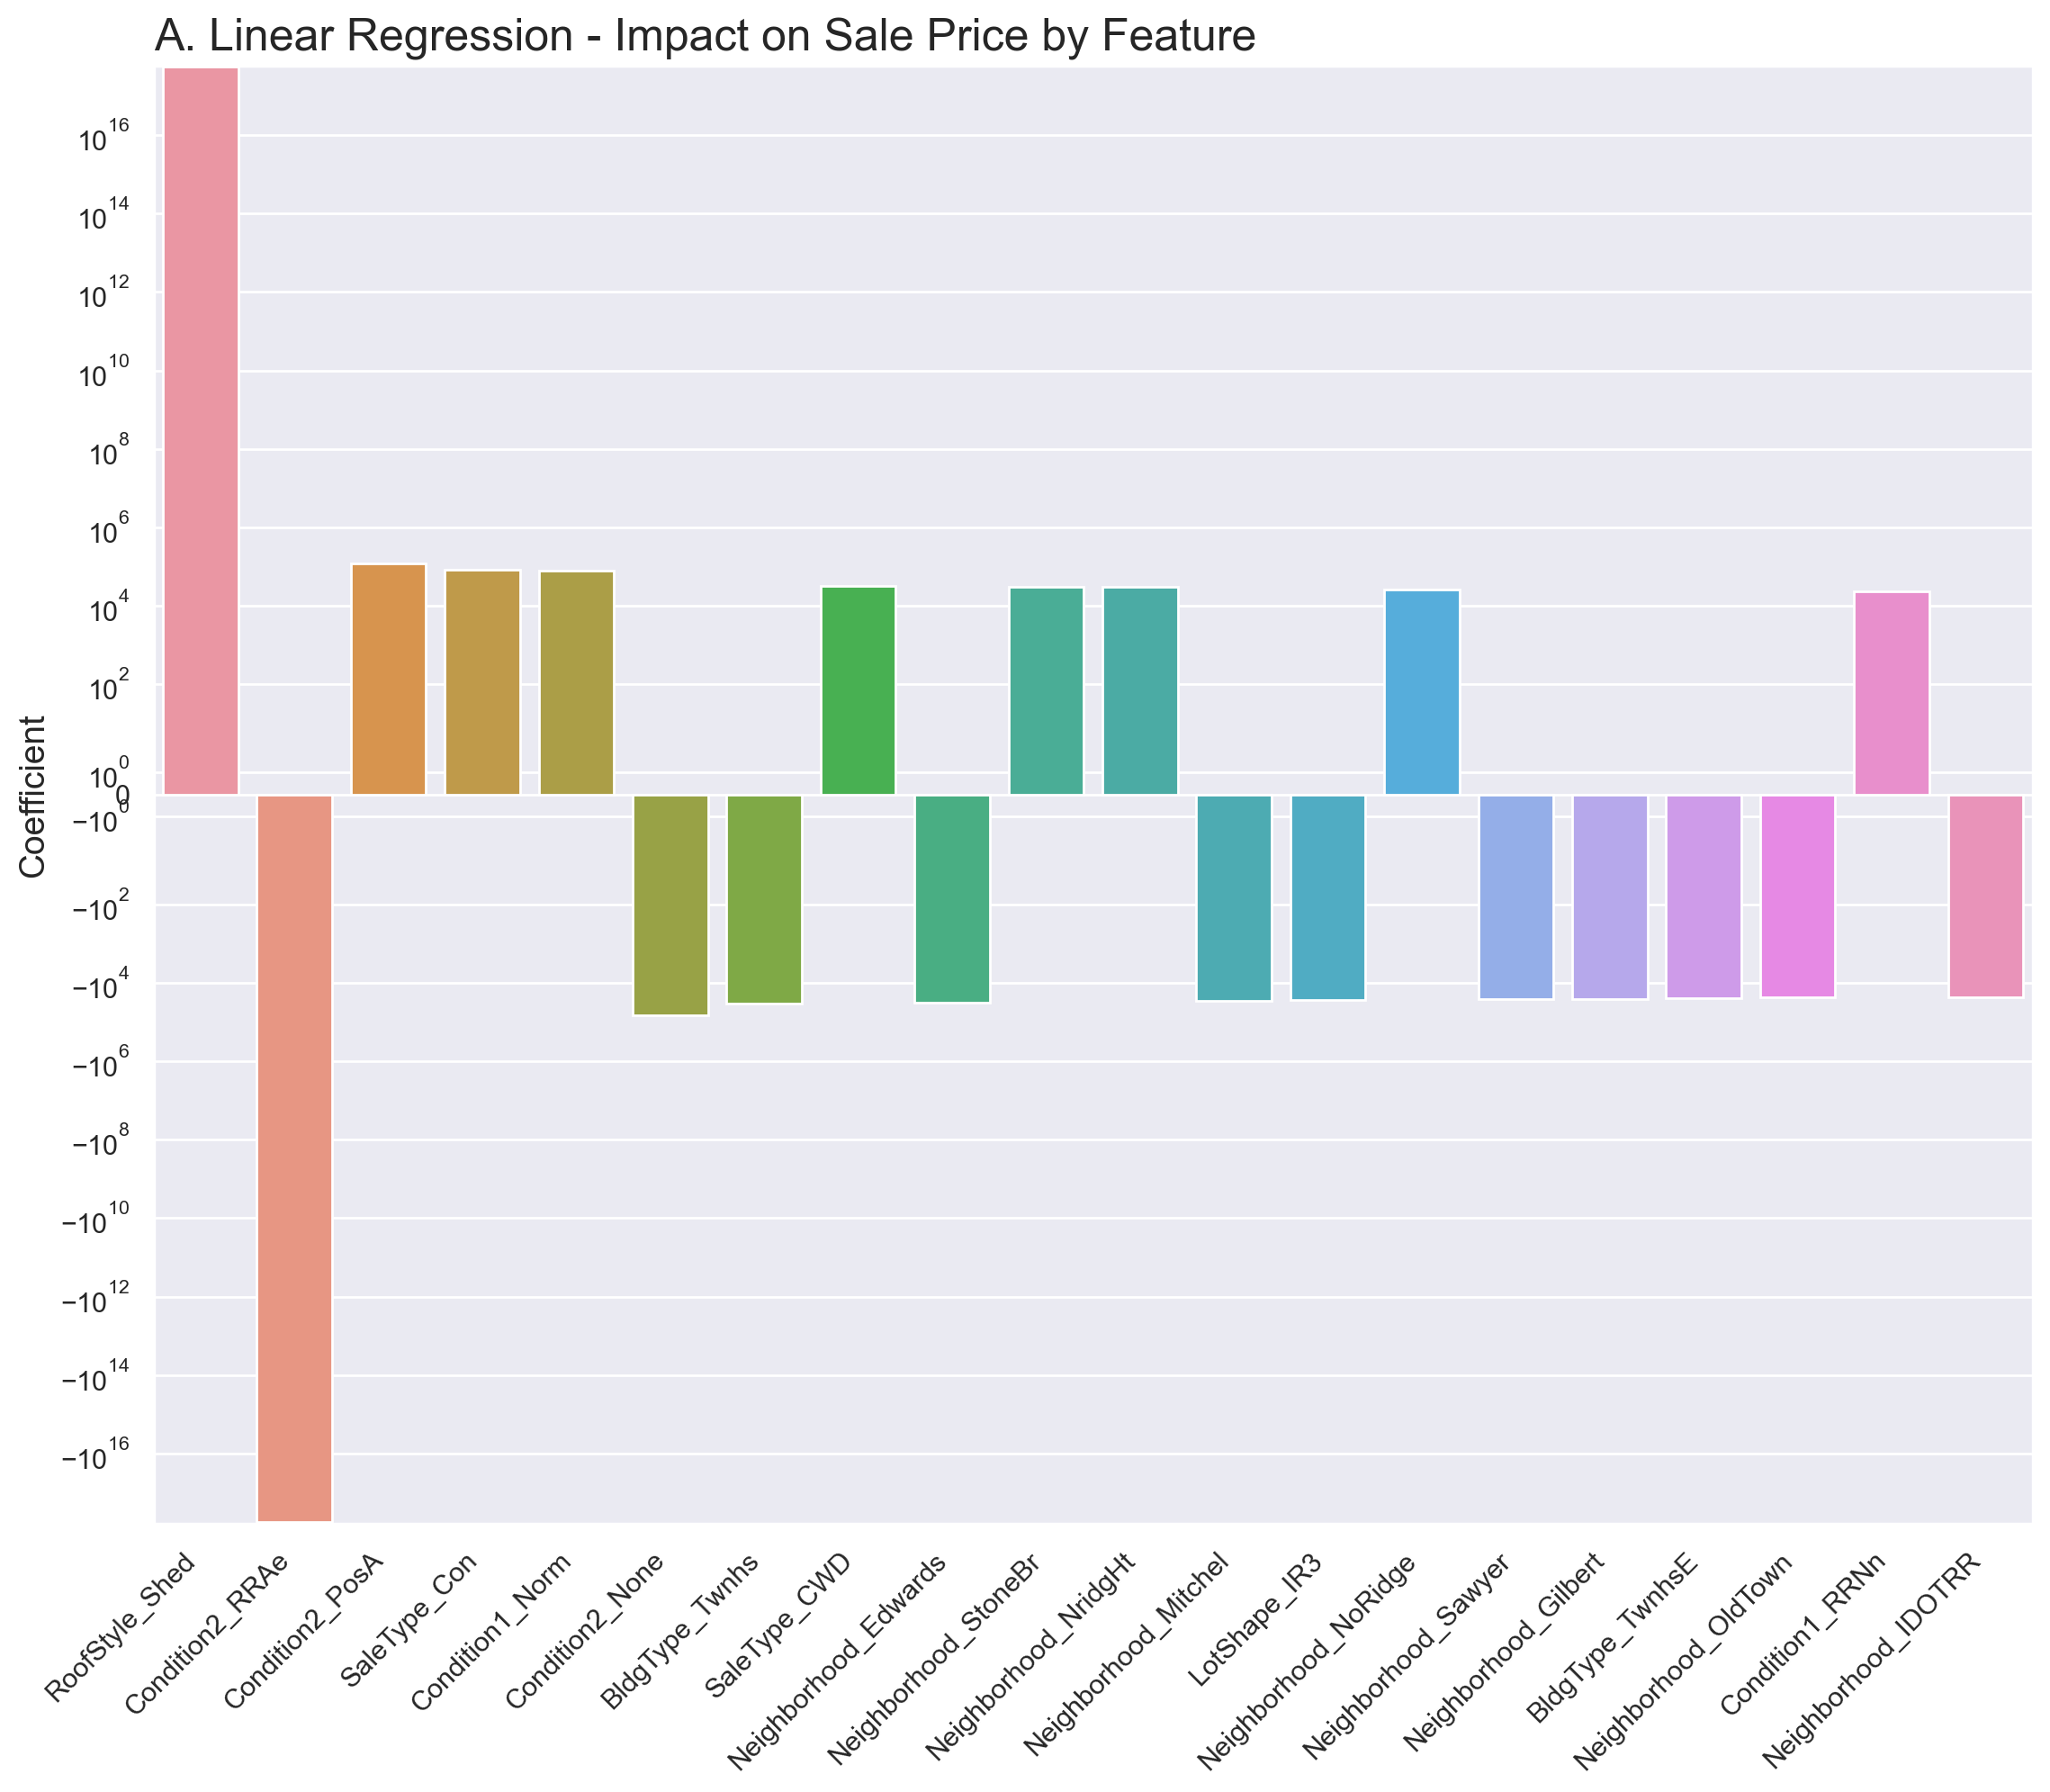

In [18]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,10))

sns.barplot(data=linreg_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('A. Linear Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.yscale('symlog')

plt.show()

### Lasso Regression with LassoCV

In [19]:
# instantiate a LassoCV model
opt_lasso = LassoCV(alphas=np.logspace(0, 5, 200), cv=10)

# fit the model
opt_lasso.fit(X_train, y_train)

# display the optimal alpha
print('Optimal Alpha:', opt_lasso.alpha_)

Optimal Alpha: 108.43659686896109


In [20]:
# instantiate the model
lasso = Lasso(alpha=opt_lasso.alpha_)

# fit the model
lasso.fit(X_train, y_train)

# calculate the scores
a_lasso_train = lasso.score(X_train, y_train)
a_lasso_test = lasso.score(X_test, y_test)
a_lasso_cv = (cross_val_score(lasso, X_train, y_train, cv = 10)).mean()

a_lasso_predictions_train = lasso.predict(X_train)
a_lasso_predictions = lasso.predict(X_test)

a_lasso_MSE = metrics.mean_squared_error(y_test, a_lasso_predictions)
a_lasso_MAE = metrics.mean_absolute_error(y_test, a_lasso_predictions)

# collect the scores in a dataframe to compare different models later
a_lasso_df = pd.DataFrame([{'train': a_lasso_train,
                            'test' : a_lasso_test,
                            'CV'   : a_lasso_cv,
                            'MSE'  : a_lasso_MSE,
                            'MAE'  : a_lasso_MAE}],
                            index = ['A. Lasso Regression'])

# score the model
print('A. Lasso Regression Scores: \n')
print('R-squared train score: ', a_lasso_train)
print('R-squared test score:  ', a_lasso_test)
print('R-squared CV score:    ', a_lasso_cv)
print('Mean Squared Error:    ', a_lasso_MSE)
print('Mean Absolute Error:   ', a_lasso_MAE)

A. Lasso Regression Scores: 

R-squared train score:  0.8263956355012392
R-squared test score:   0.8515969675101209
R-squared CV score:     0.7693202198396144
Mean Squared Error:     515304652.3274721
Mean Absolute Error:    16737.20356691819


In [21]:
# display the model intercept
print('Intercept:', lasso.intercept_)

Intercept: 166819.2350155963


In [22]:
# collect the model coefficients in a dataframe
lasso_coef = pd.DataFrame(list(zip(X_train.columns, lasso.coef_)), columns = ['variable','coefficient'])
lasso_coef['coef_abs'] = abs(lasso_coef['coefficient'])

# display the largest model coefficients
lasso_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

,variable,coefficient,coef_abs
48,Neighborhood_NridgHt,34567.608110,34567.608110
47,Neighborhood_NoRidge,33235.122888,33235.122888
54,Neighborhood_StoneBr,27276.677170,27276.677170
38,Neighborhood_Crawfor,23595.616549,23595.616549
73,BldgType_Twnhs,-21510.508453,21510.508453
53,Neighborhood_Somerst,21243.449915,21243.449915
24,LotShape_IR3,-17249.293777,17249.293777
16,TotalSF,17224.955176,17224.955176
39,Neighborhood_Edwards,-15630.662695,15630.662695
74,BldgType_TwnhsE,-13492.533385,13492.533385


In [23]:
# display the coefficients which has been reduced to 0
lasso_zeroed = lasso_coef[lasso_coef['coefficient'] == 0].shape[0]
print('Lasso Regression has zeroed',lasso_zeroed , 'coefficients.')
list(lasso_coef['variable'][lasso_coef['coefficient'] == 0].values)

Lasso Regression has zeroed 50 coefficients.


['LotFrontage',
 'LandSlope',
 'MiscVal',
 'MSZoning_RH',
 'LotShape_IR2',
 'LandContour_Low',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_ClearCr',
 'Neighborhood_IDOTRR',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_SWISU',
 'Neighborhood_SawyerW',
 'Condition1_PosA',
 'Condition1_PosN',
 'Condition1_RRAe',
 'Condition1_RRAn',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'Condition2_None',
 'Condition2_Norm',
 'Condition2_PosA',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'BldgType_2fmCon',
 'BldgType_Duplex',
 'HouseStyle_1.5Unf',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'HouseStyle_2Story',
 'RoofStyle_Gambrel',
 'RoofStyle_Hip',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'Foundation_Stone',
 'Foundation_Wood',
 'SaleType_CWD',
 'SaleType_Con',
 'SaleType_ConLD',
 'SaleType_ConLI',
 'SaleType_ConLw',
 'SaleType_Oth',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca',
 'SaleCondition_Family

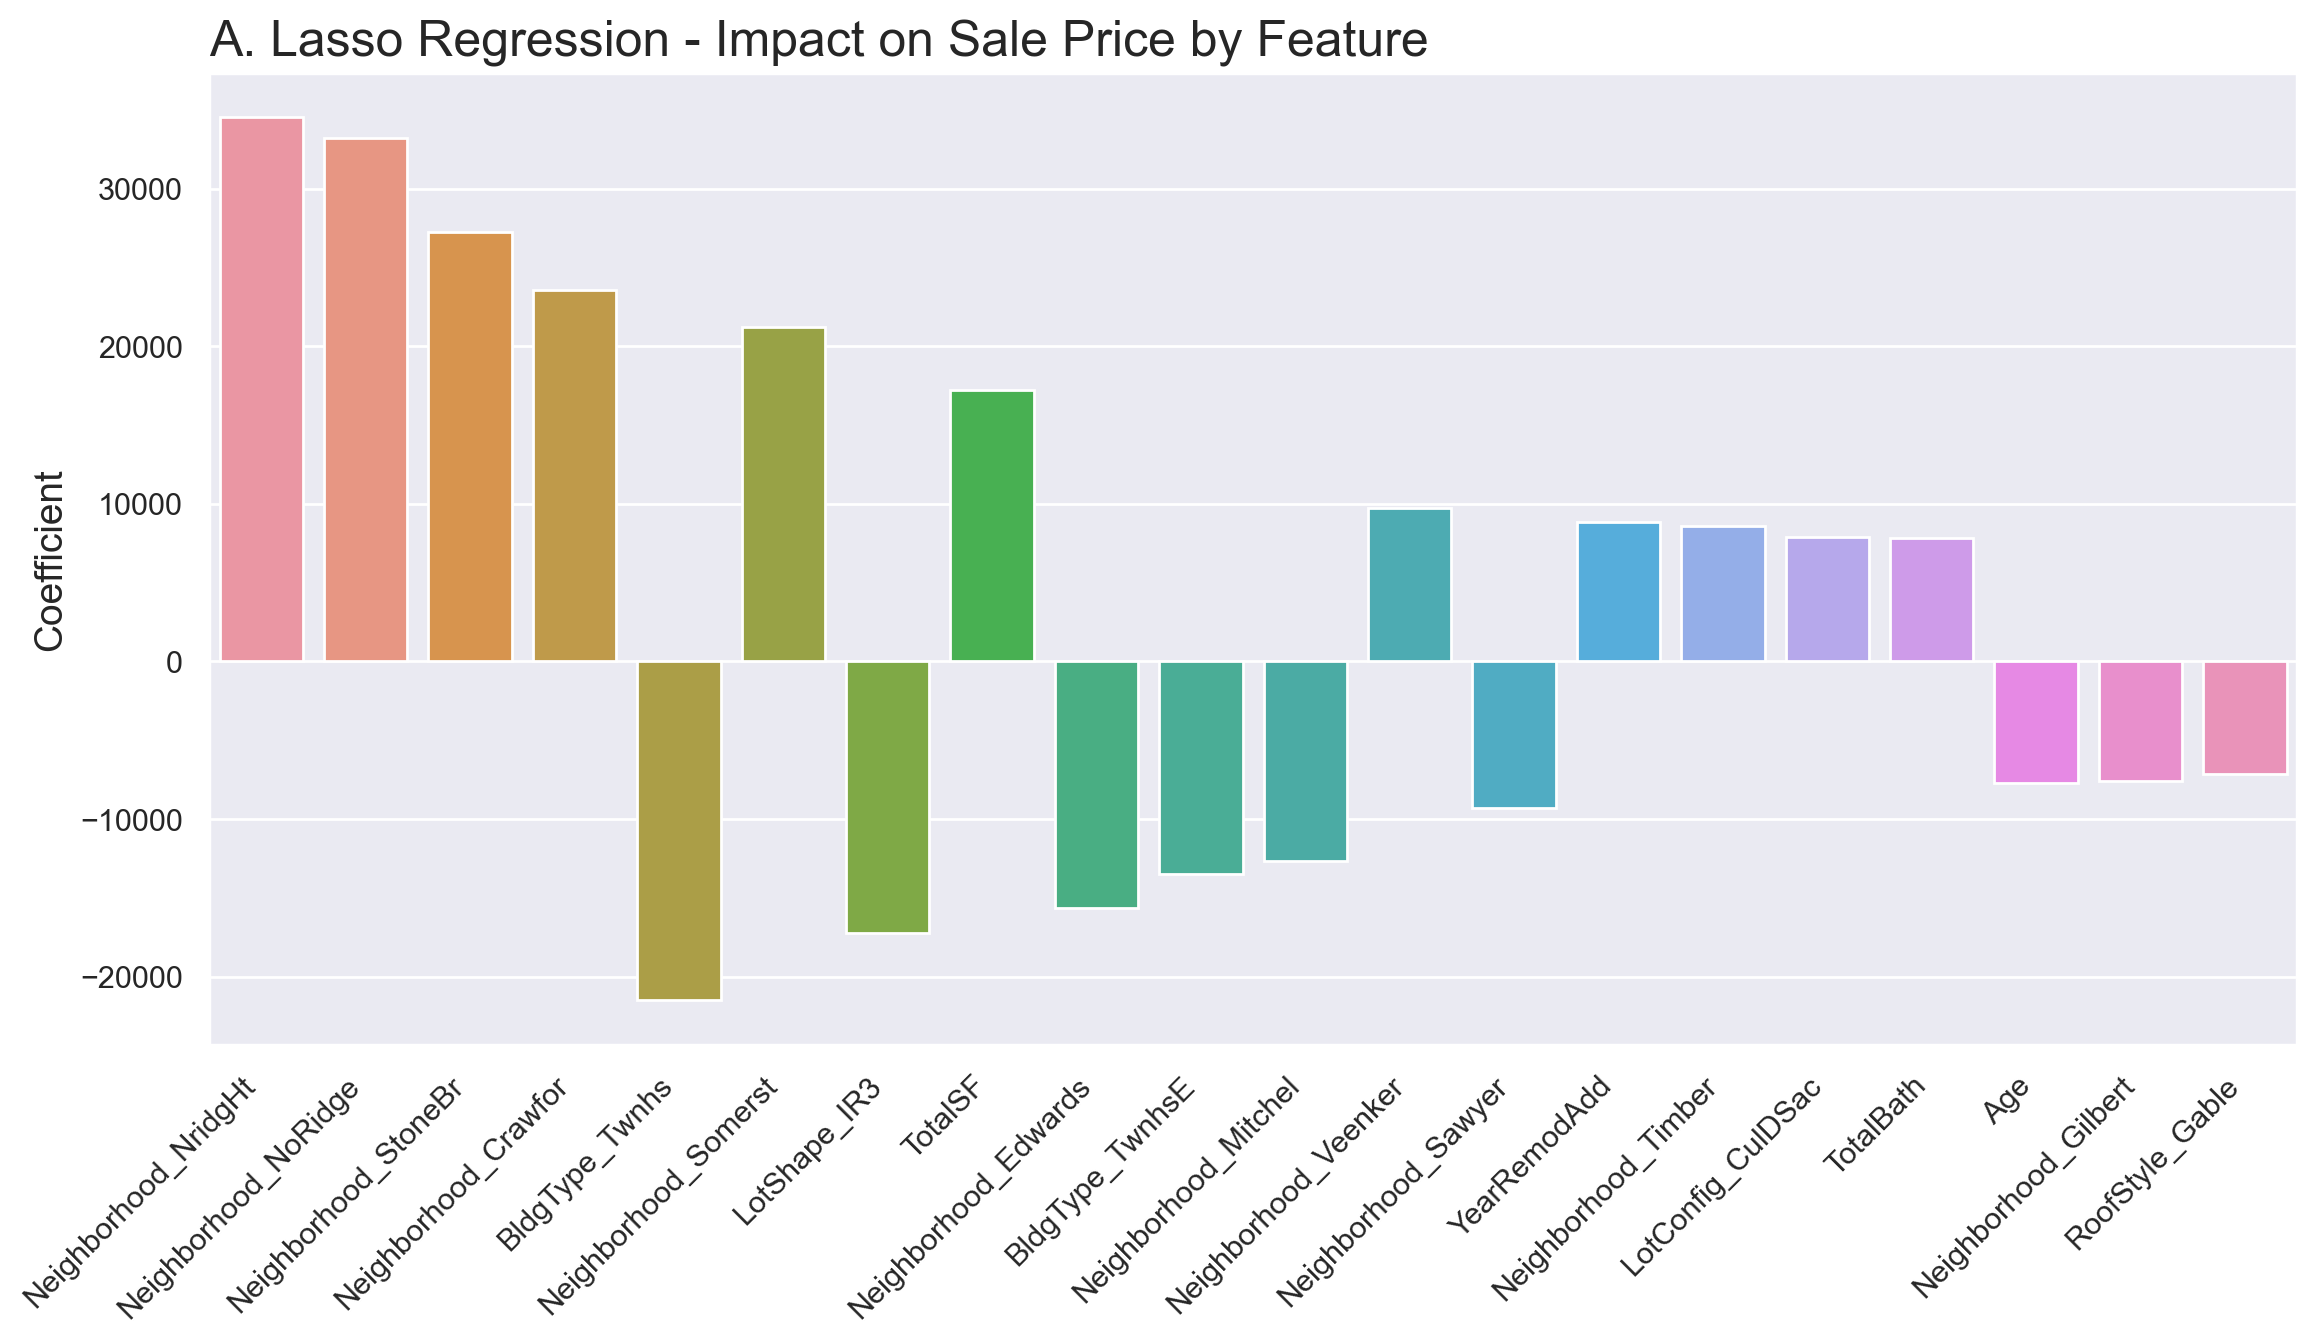

In [24]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=lasso_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('A. Lasso Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Ridge Regression with RidgeCV

In [25]:
# instantiate a RidgeCV model
opt_ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)

# fit the model
opt_ridge.fit(X_train, y_train)

# display the optimal alpha
print('Optimal Alpha:', opt_ridge.alpha_)

Optimal Alpha: 7.575250258771915


In [26]:
# instantiate the model
ridge = Ridge(alpha=opt_ridge.alpha_)

# fit the model
ridge.fit(X_train, y_train)

# calculate the scores
a_ridge_train = ridge.score(X_train, y_train)
a_ridge_test = ridge.score(X_test, y_test)
a_ridge_cv = (cross_val_score(ridge, X_train, y_train, cv = 10)).mean()

a_ridge_predictions_train = ridge.predict(X_train)
a_ridge_predictions = ridge.predict(X_test)

a_ridge_MSE = metrics.mean_squared_error(y_test, a_ridge_predictions)
a_ridge_MAE = metrics.mean_absolute_error(y_test, a_ridge_predictions)

# collect the scores in a dataframe to compare different models later
a_ridge_df = pd.DataFrame([{'train': a_ridge_train,
                            'test' : a_ridge_test,
                            'CV'   : a_ridge_cv,
                            'MSE'  : a_ridge_MSE,
                            'MAE'  : a_ridge_MAE}],
                            index = ['A. Ridge Regression'])

# score the model
print('A. Ridge Regression Scores: \n')
print('R-squared train score: ', a_ridge_train)
print('R-squared test score:  ', a_ridge_test)
print('R-squared CV score:    ', a_ridge_cv)
print('Mean Squared Error:    ', a_ridge_MSE)
print('Mean Absolute Error:   ', a_ridge_MAE)

A. Ridge Regression Scores: 

R-squared train score:  0.8328214401246292
R-squared test score:   0.8518910034775479
R-squared CV score:     0.7688591487523795
Mean Squared Error:     514283661.7221956
Mean Absolute Error:    16850.690251722084


In [27]:
# display the model intercept
print('Intercept:', ridge.intercept_)

Intercept: 165821.53424877883


In [28]:
# collect the model coefficients in a dataframe
ridge_coef = pd.DataFrame(list(zip(X_train.columns, ridge.coef_)), columns = ['variable','coefficient'])
ridge_coef['coef_abs'] = abs(ridge_coef['coefficient'])

# display the largest model coefficients
ridge_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

,variable,coefficient,coef_abs
48,Neighborhood_NridgHt,26704.476437,26704.476437
47,Neighborhood_NoRidge,24798.327884,24798.327884
54,Neighborhood_StoneBr,20234.077003,20234.077003
39,Neighborhood_Edwards,-20101.398754,20101.398754
38,Neighborhood_Crawfor,18912.612804,18912.612804
73,BldgType_Twnhs,-18473.759830,18473.759830
16,TotalSF,17629.362262,17629.362262
43,Neighborhood_Mitchel,-17301.578130,17301.578130
24,LotShape_IR3,-16643.622255,16643.622255
58,Condition1_Norm,15334.531062,15334.531062


In [29]:
# display the coefficients which has been reduced to 0
ridge_zeroed = ridge_coef[ridge_coef['coefficient'] == 0].shape[0]
print('Ridge Regression has zeroed',ridge_zeroed , 'coefficients.')
list(ridge_coef['variable'][ridge_coef['coefficient'] == 0].values)

Ridge Regression has zeroed 0 coefficients.


[]

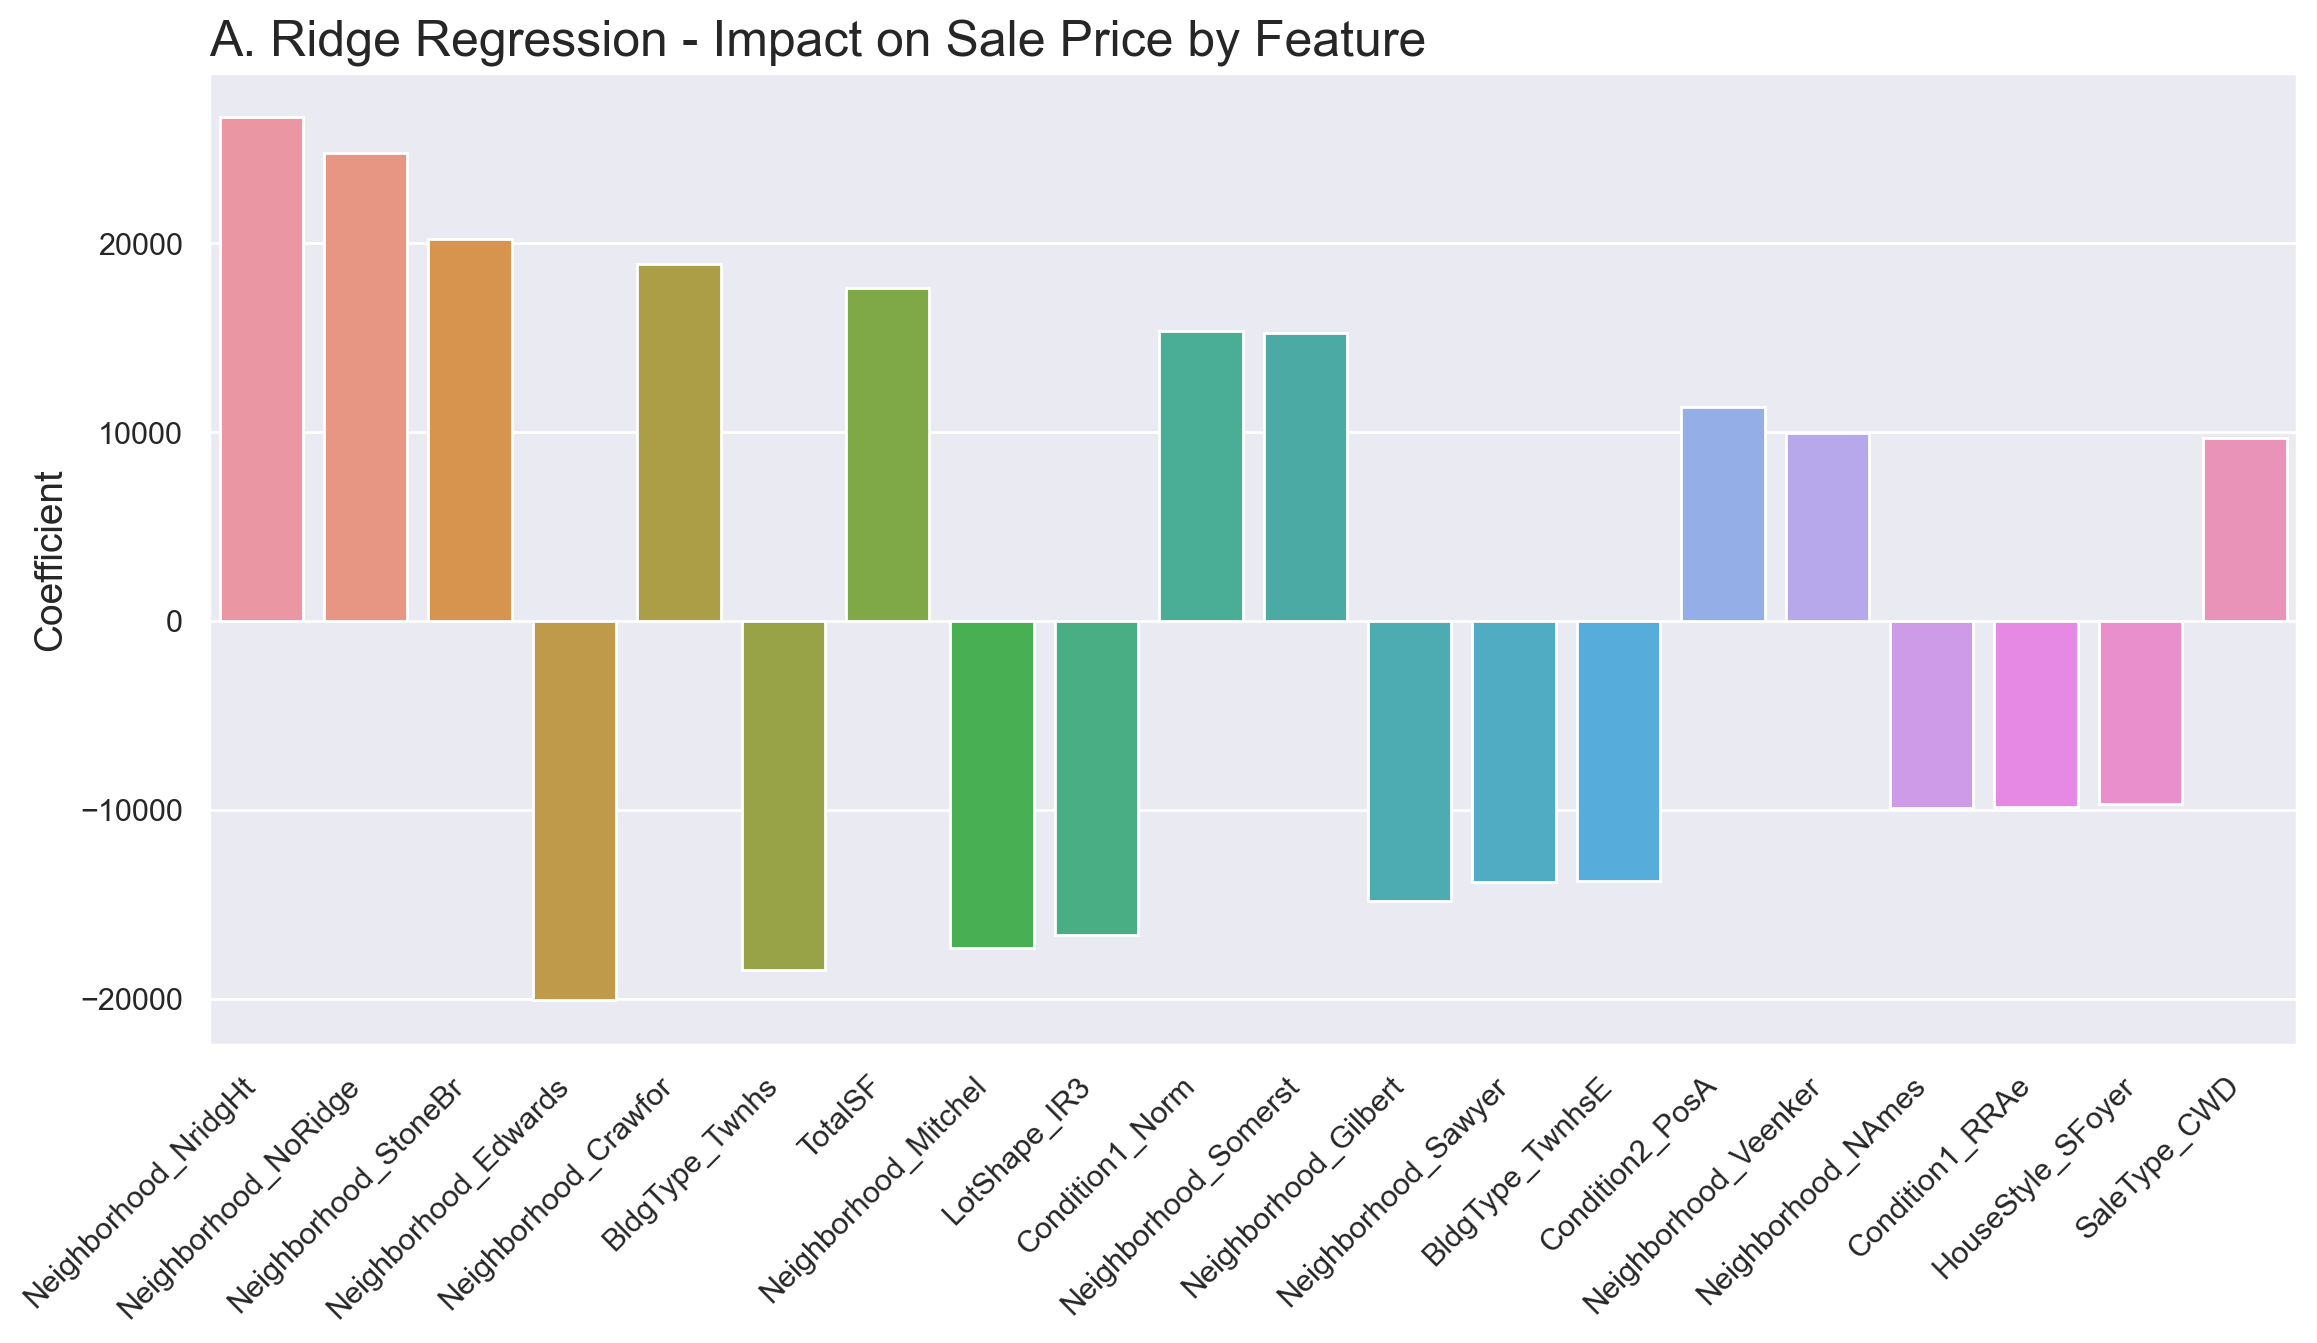

In [30]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=ridge_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('A. Ridge Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Elastic Net Regression with ElasticNetCV

In [31]:
# instantiate a ElasticnetCV model
opt_enet = ElasticNetCV(alphas=np.logspace(-4, 4, 10), l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                        max_iter = 100000, cv=10)

# fit the model
opt_enet.fit(X_train, y_train)

# display the optimal alpha and L1 ratio
print('Optimal Alpha:', opt_enet.alpha_)
print('Optimal L1 ratio:', opt_enet.l1_ratio_)

Optimal Alpha: 0.005994842503189409
Optimal L1 ratio: 0.1


In [32]:
# instantiate the model
enet = ElasticNet(alpha=opt_enet.alpha_, l1_ratio=opt_enet.l1_ratio_)

# fit the model
enet.fit(X_train, y_train)

# calculate the scores
a_enet_train = enet.score(X_train, y_train)
a_enet_test = enet.score(X_test, y_test)
a_enet_cv = (cross_val_score(enet, X_train, y_train, cv = 10)).mean()

a_enet_predictions_train = enet.predict(X_train)
a_enet_predictions = enet.predict(X_test)

a_enet_MSE = metrics.mean_squared_error(y_test, a_enet_predictions)
a_enet_MAE = metrics.mean_absolute_error(y_test, a_enet_predictions)

# collect the scores in a dataframe to compare different models later
a_enet_df = pd.DataFrame([{'train': a_enet_train,
                           'test' : a_enet_test,
                           'CV'   : a_enet_cv,
                           'MSE'  : a_enet_MSE,
                           'MAE'  : a_enet_MAE}],
                           index = ['A. Elastic Net Regression'])

# score the model
print('A. Elastic Net Regression Scores: \n')
print('R-squared train score: ', a_enet_train)
print('R-squared test score:  ', a_enet_test)
print('R-squared CV score:    ', a_enet_cv)
print('Mean Squared Error:    ', a_enet_MSE)
print('Mean Absolute Error:   ', a_enet_MAE)

A. Elastic Net Regression Scores: 

R-squared train score:  0.8339107848644768
R-squared test score:   0.8519815327853066
R-squared CV score:     0.7686513830560476
Mean Squared Error:     513969313.87715906
Mean Absolute Error:    16879.860020537104


In [33]:
# display the model intercept
print('Intercept:', enet.intercept_)

Intercept: 165558.5719787339


In [34]:
# collect the model coefficients in a dataframe
enet_coef = pd.DataFrame(list(zip(X_train.columns, enet.coef_)), columns = ['variable','coefficient'])
enet_coef['coef_abs'] = abs(enet_coef['coefficient'])

# display the largest model coefficients
enet_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

,variable,coefficient,coef_abs
48,Neighborhood_NridgHt,27573.252150,27573.252150
47,Neighborhood_NoRidge,25708.369557,25708.369557
54,Neighborhood_StoneBr,21510.405757,21510.405757
39,Neighborhood_Edwards,-20566.782775,20566.782775
73,BldgType_Twnhs,-19641.169470,19641.169470
38,Neighborhood_Crawfor,19176.484781,19176.484781
43,Neighborhood_Mitchel,-17785.870556,17785.870556
16,TotalSF,17578.315642,17578.315642
24,LotShape_IR3,-17533.039078,17533.039078
58,Condition1_Norm,16819.134105,16819.134105


In [35]:
# display the coefficients which has been reduced to 0
enet_zeroed = enet_coef[enet_coef['coefficient'] == 0].shape[0]
print('Elastic Net Regression has zeroed',enet_zeroed , 'coefficients.')
list(enet_coef['variable'][enet_coef['coefficient'] == 0].values)

Elastic Net Regression has zeroed 0 coefficients.


[]

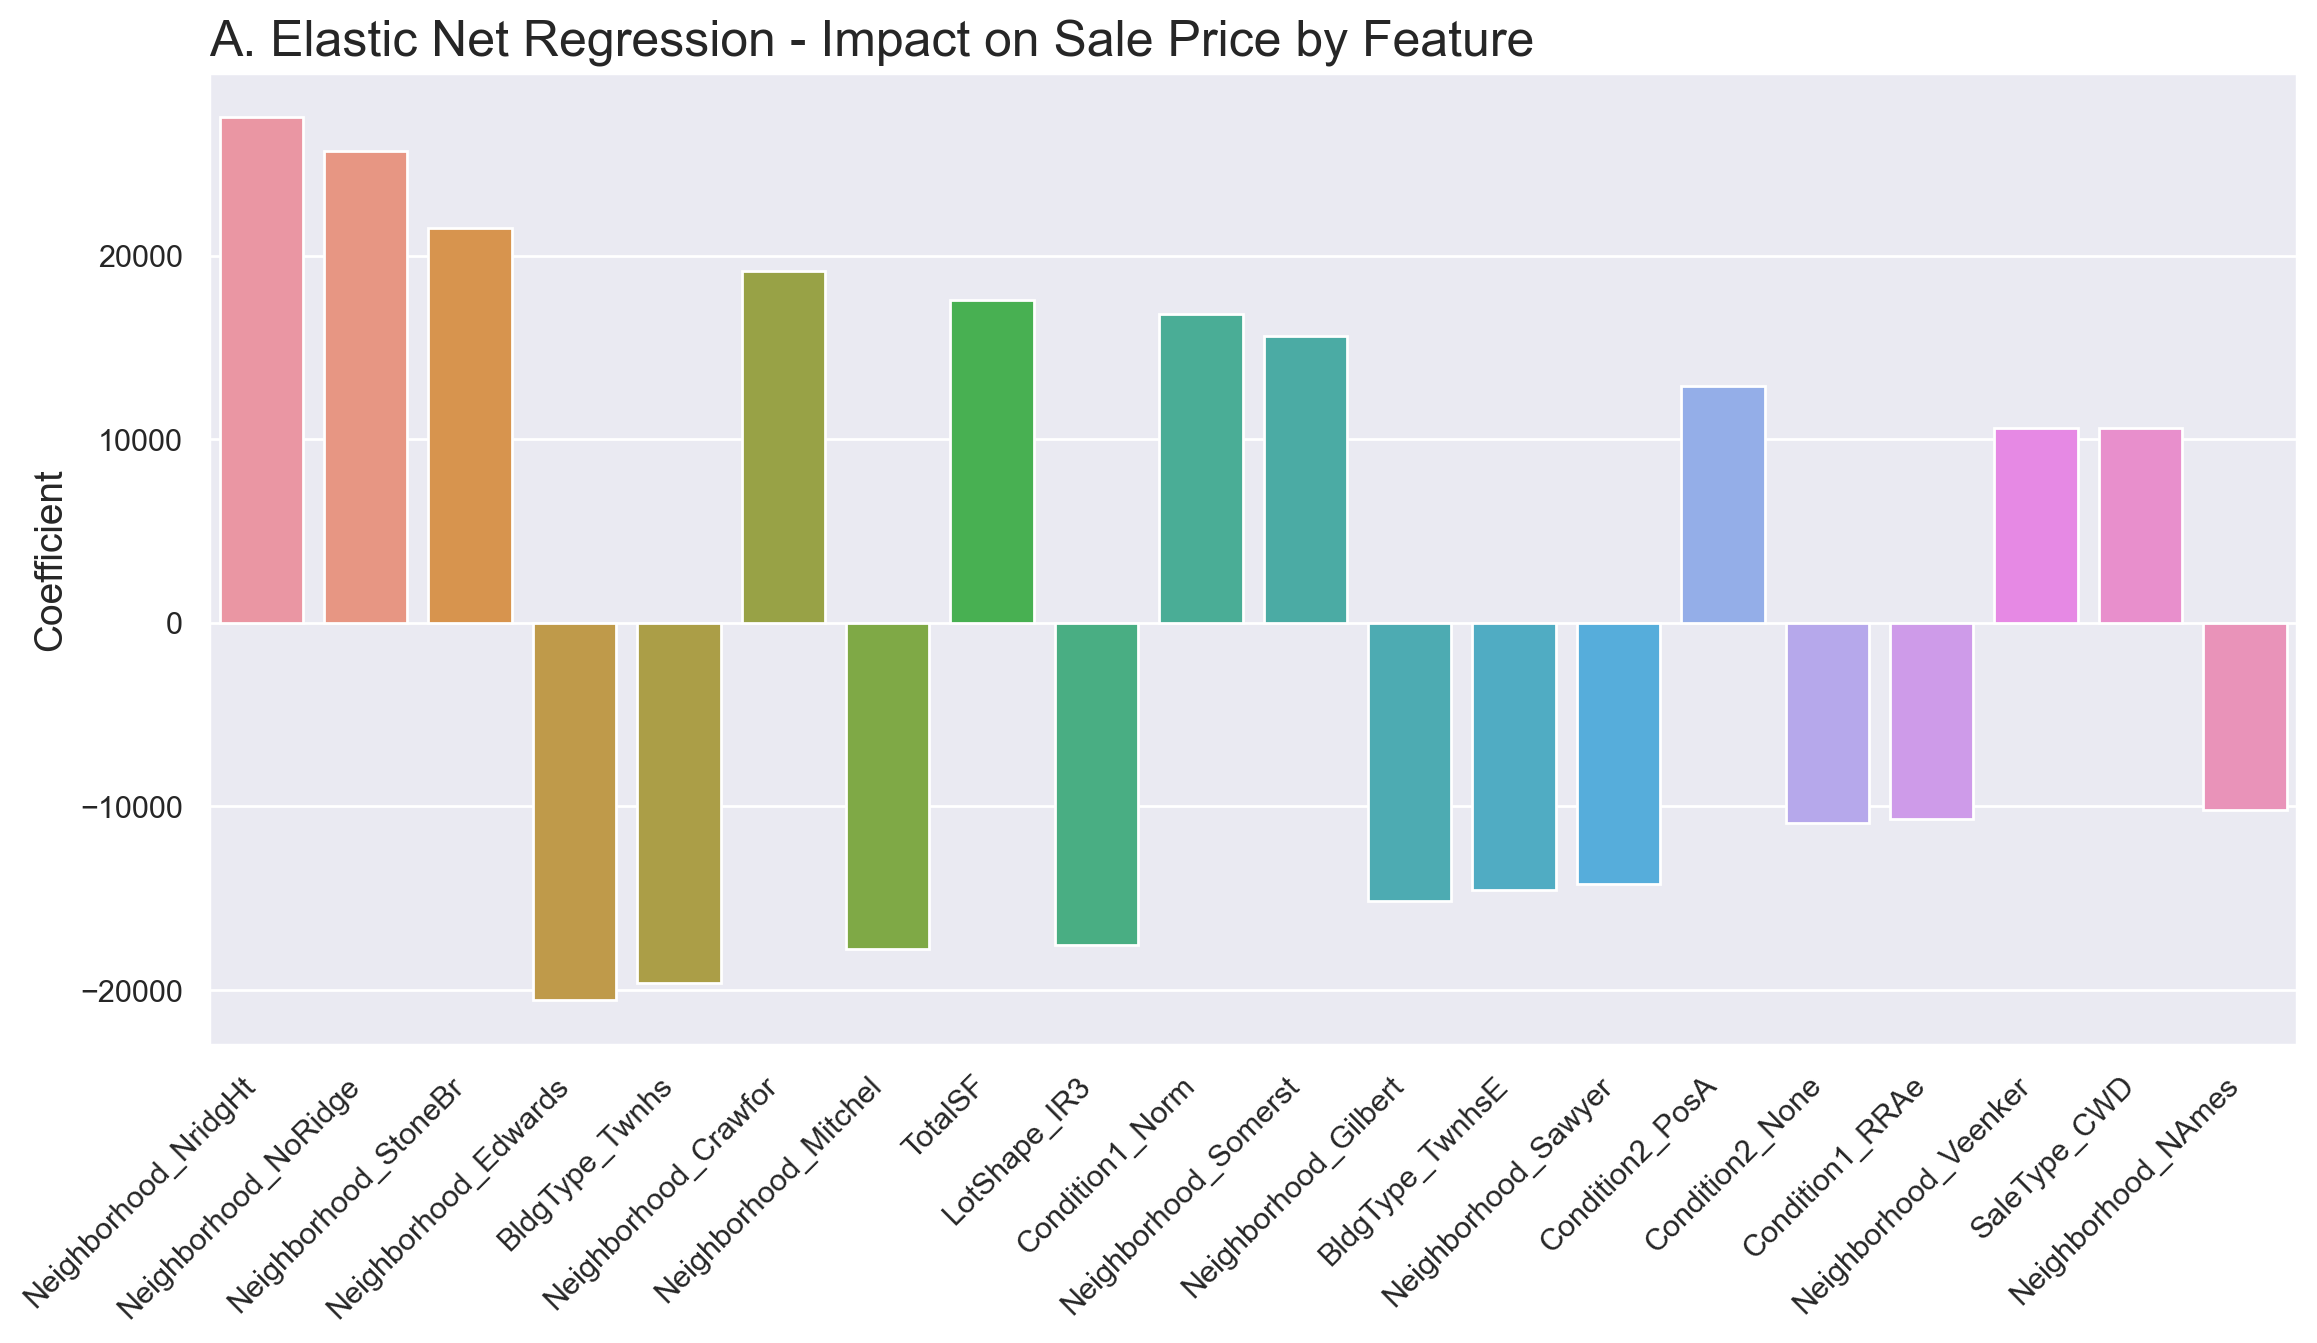

In [36]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=enet_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('A. Elastic Net Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Model Set Score Evaluation

In [37]:
A_models = pd.concat([a_linreg_df, a_lasso_df, a_ridge_df, a_enet_df], axis = 0)
A_models.round(decimals=5)

,A. Linear Reg,A. Lasso Reg,A. Ridge Reg,A. El-net Reg
train,8.443500e-01,8.264000e-01,8.328200e-01,8.339100e-01
test,-5.340567e+23,8.516000e-01,8.518900e-01,8.519800e-01
CV,-2.351305e+23,7.693200e-01,7.688600e-01,7.686500e-01
MSE,1.854422e+33,5.153047e+08,5.142837e+08,5.139693e+08
MAE,3.352450e+15,1.673720e+04,1.685069e+04,1.687986e+04


Among the four models implemented above, **Elastic Net Regression** achieved the highest test score of **0.8519**  

<br/><br/>

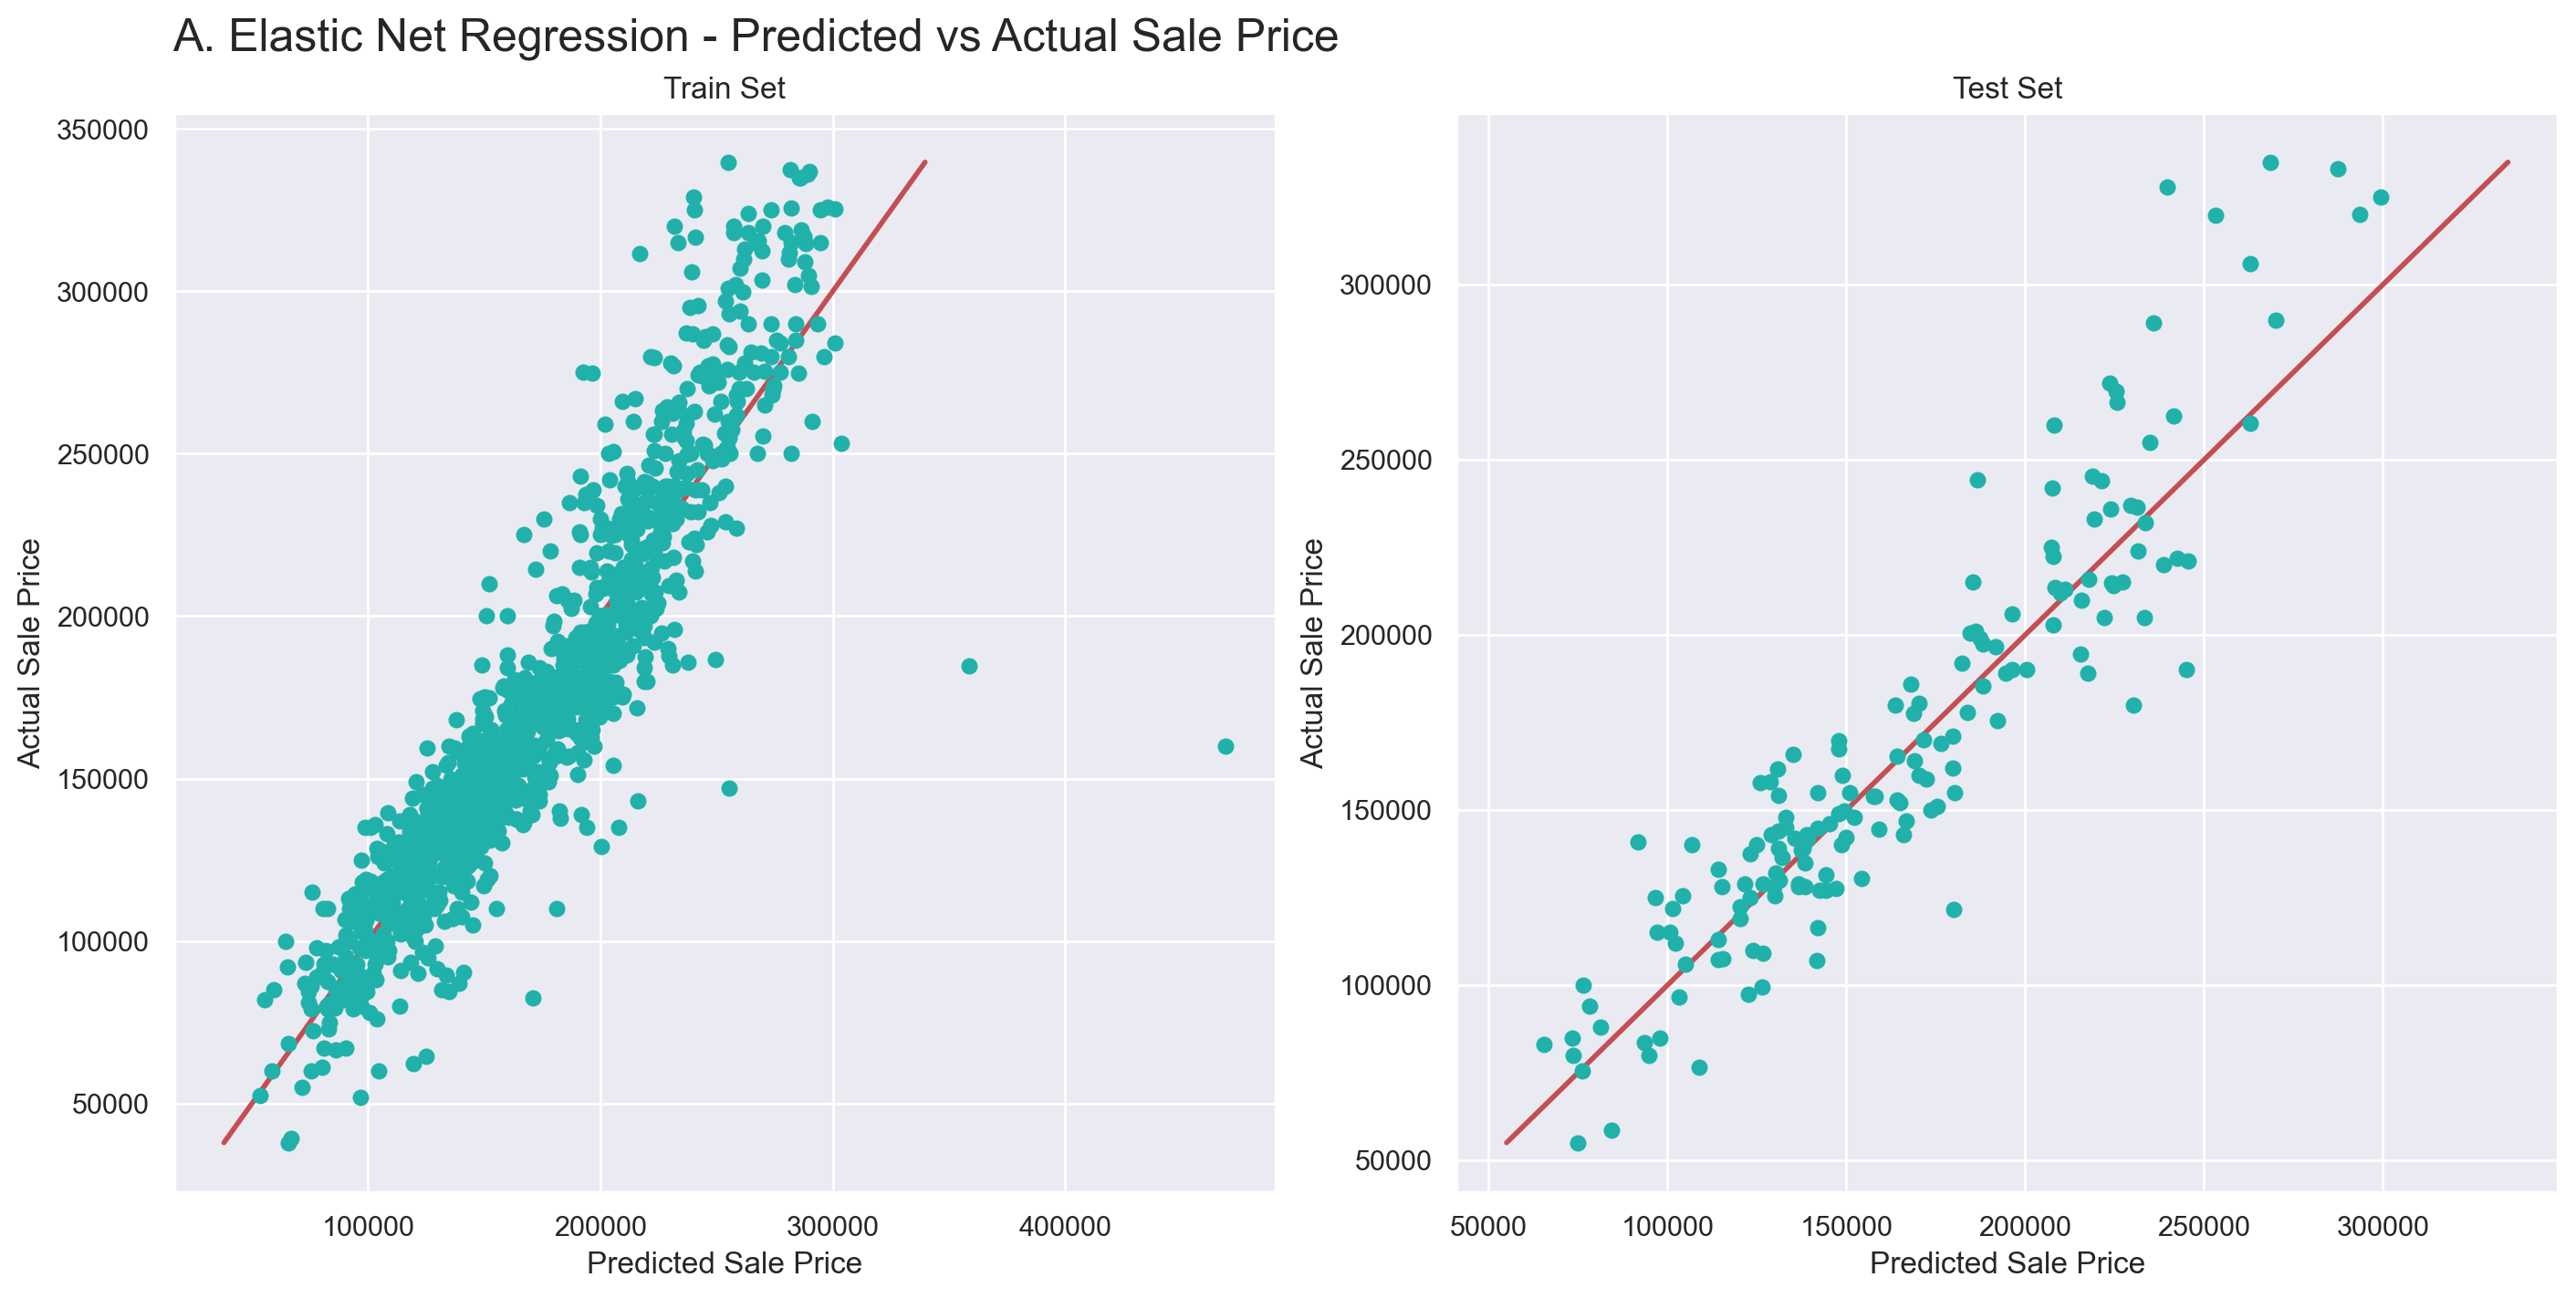

In [38]:
# plot the predicted y values against the actual y values by the elastic net method
fig, ax = plt.subplots(ncols=2, figsize=(14, 7), constrained_layout=True)

fig.suptitle('A. Elastic Net Regression - Predicted vs Actual Sale Price', x=0.52, horizontalalignment='right', fontsize=18)

ax[0].scatter(a_enet_predictions_train, y_train, s=30, color = 'lightseagreen', zorder=10)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='r', lw=2)
ax[0].set_ylabel('Actual Sale Price')
ax[0].set_xlabel('Predicted Sale Price')
ax[0].set_title('Train Set')

ax[1].scatter(a_enet_predictions, y_test, s=30, color='lightseagreen', zorder=10)
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r', lw=2)
ax[1].set_ylabel('Actual Sale Price')
ax[1].set_xlabel('Predicted Sale Price')
ax[1].set_title('Test Set')

plt.show()

In [49]:
# calculate the residuals for the elastic net method for the train dataset
a_res_train = pd.DataFrame({'y_train': y_train, 'y_hat' : a_enet_predictions_train})
a_res_train['residuals'] = a_res_train['y_train'] - a_res_train['y_hat']

# calculate the residuals for the lasso method for the test dataset
a_res_test = pd.DataFrame({'y_test': y_test, 'y_hat' : a_enet_predictions})
a_res_test['residuals'] = a_res_test['y_test'] - a_res_test['y_hat']

print(a_res_test.shape)
a_res_test.head(20)

(165, 3)


,y_test,y_hat,residuals
15,149000,147819.133903,1180.866097
23,154000,158000.678560,-4000.678560
25,134800,138499.190489,-3699.190489
26,306000,262965.347633,43034.652367
31,165500,164206.470028,1293.529972
36,109000,126596.488592,-17596.488592
43,319900,253228.443660,66671.556340
50,110000,123759.057948,-13759.057948
59,140000,106662.107892,33337.892108
62,180000,230188.745755,-50188.745755


### Conclusions  


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [57]:
# load the data
df_m = pd.read_csv('datasets/house_03_mutable_optimised.csv')

In [58]:
# add YrSold to perform train/test split
df_m['YrSold'] = df_f['YrSold']

In [59]:
# dummify categorical variables
df_m_dum = pd.get_dummies(df_m, columns=[x for x in df_m.columns if x in nominal_vars], drop_first=True)

In [60]:
df_m_dum.head()

,OverallQual,OverallCond,MasVnrArea,ExterCond,BsmtFinType1,BsmtFinType2,BsmtUnfSF,HeatingQC,CentralAir,LowQualFinSF,Functional,FireplaceQu,GarageFinish,GarageQual,PavedDrive,Fence,SalePrice,YrSold,Alley_None,Alley_Pave,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_None,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr
0,7,5,196.0,3,6,1,150,5,1,0,8,0,2,3,3,0,208500,2008,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
1,6,8,0.0,3,5,1,284,5,1,0,8,3,2,3,3,0,181500,2007,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
2,7,5,162.0,3,6,1,434,5,1,0,8,3,2,3,3,0,223500,2008,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
3,7,5,0.0,3,5,1,540,4,1,0,8,4,1,3,3,0,140000,2006,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1
4,8,5,350.0,3,6,1,490,5,1,0,8,3,2,3,3,0,250000,2008,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1


In [62]:
# create a train-test split based on YrSold (pre-2010 is train, 2010 is test)
X_train = df_m_dum[df_m_dum['YrSold'] < 2010].copy()
X_test = df_m_dum[df_m_dum['YrSold'] == 2010].copy()

y_train = X_train.pop('SalePrice')
y_test = X_test.pop('SalePrice')

In [63]:
# drop YrSold since this is not a changeable feature
X_train.drop('YrSold', axis = 1, inplace = True)
X_test.drop('YrSold', axis = 1, inplace = True)

In [64]:
# check the shape of the modelling sets
print('Training set shape')
print('X:', X_train.shape)
print('y:', y_train.shape)
print('')
print('Test set shape')
print('X:', X_test.shape)
print('y:', y_test.shape)

Training set shape
X: (1214, 65)
y: (1214,)

Test set shape
X: (165, 65)
y: (165,)


In [65]:
# select quantitative features which still are in the dataframe
quant_cols = [x for x in X_train.columns if x in quant_vars]

# rescale the numerical values in train and test sets
scaler = StandardScaler()
X_train[quant_cols] = scaler.fit_transform(X_train[quant_cols])
X_test[quant_cols] = scaler.transform(X_test[quant_cols])

### Linear Regression (without regularisation)

In [70]:
# instantiate the model
linreg = LinearRegression()

# fit the model
linreg.fit(X_train, y_train)

# calculate the scores
b_linreg_train = linreg.score(X_train, y_train)
b_linreg_test = linreg.score(X_test, y_test)
b_linreg_cv = (cross_val_score(linreg, X_train, y_train, cv = 10)).mean()

b_linreg_predictions_train = linreg.predict(X_train)
b_linreg_predictions = linreg.predict(X_test)

b_linreg_MSE = metrics.mean_squared_error(y_test, b_linreg_predictions)
b_linreg_MAE = metrics.mean_absolute_error(y_test, b_linreg_predictions)

# collect the scores in a dataframe to compare different models later
b_linreg_df = pd.DataFrame([{'train': b_linreg_train,
                             'test' : b_linreg_test,
                             'CV'   : b_linreg_cv,
                             'MSE'  : b_linreg_MSE,
                             'MAE'  : b_linreg_MAE}],
                             index = ['B. Linear Regression'])

# score the model
print('B. Linear Regression Scores: \n')
print('R-squared train score: ', b_linreg_train)
print('R-squared test score:  ', b_linreg_test)
print('R-squared CV score:    ', b_linreg_cv)
print('Mean Squared Error:    ', b_linreg_MSE)
print('Mean Absolute Error:   ', b_linreg_MAE)

B. Linear Regression Scores: 

R-squared train score:  0.7341012523406081
R-squared test score:   -6.784484718421115e+24
R-squared CV score:     -2.3773022882501372e+23
Mean Squared Error:     2.355798584699049e+34
Mean Absolute Error:    1.1948877428466816e+16


In [72]:
# display the model intercept
print('Intercept:', linreg.intercept_)

Intercept: -214600.42778831927


In [73]:
# collect the model coefficients in a dataframe
linreg_coef = pd.DataFrame(list(zip(X_train.columns, linreg.coef_)), columns = ['variable','coefficient'])
linreg_coef['coef_abs'] = abs(linreg_coef['coefficient'])

# display the largest model coefficients
linreg_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

,variable,coefficient,coef_abs
25,Exterior1st_AsphShn,1.971565e+18,1.971565e+18
24,RoofMatl_WdShngl,1.954489e+05,1.954489e+05
19,RoofMatl_Membran,1.928580e+05,1.928580e+05
22,RoofMatl_Tar&Grv,1.869119e+05,1.869119e+05
18,RoofMatl_CompShg,1.649642e+05,1.649642e+05
23,RoofMatl_WdShake,1.648896e+05,1.648896e+05
20,RoofMatl_Metal,1.608604e+05,1.608604e+05
21,RoofMatl_Roll,1.393306e+05,1.393306e+05
46,Exterior2nd_Other,7.254086e+04,7.254086e+04
59,Heating_OthW,-4.261414e+04,4.261414e+04


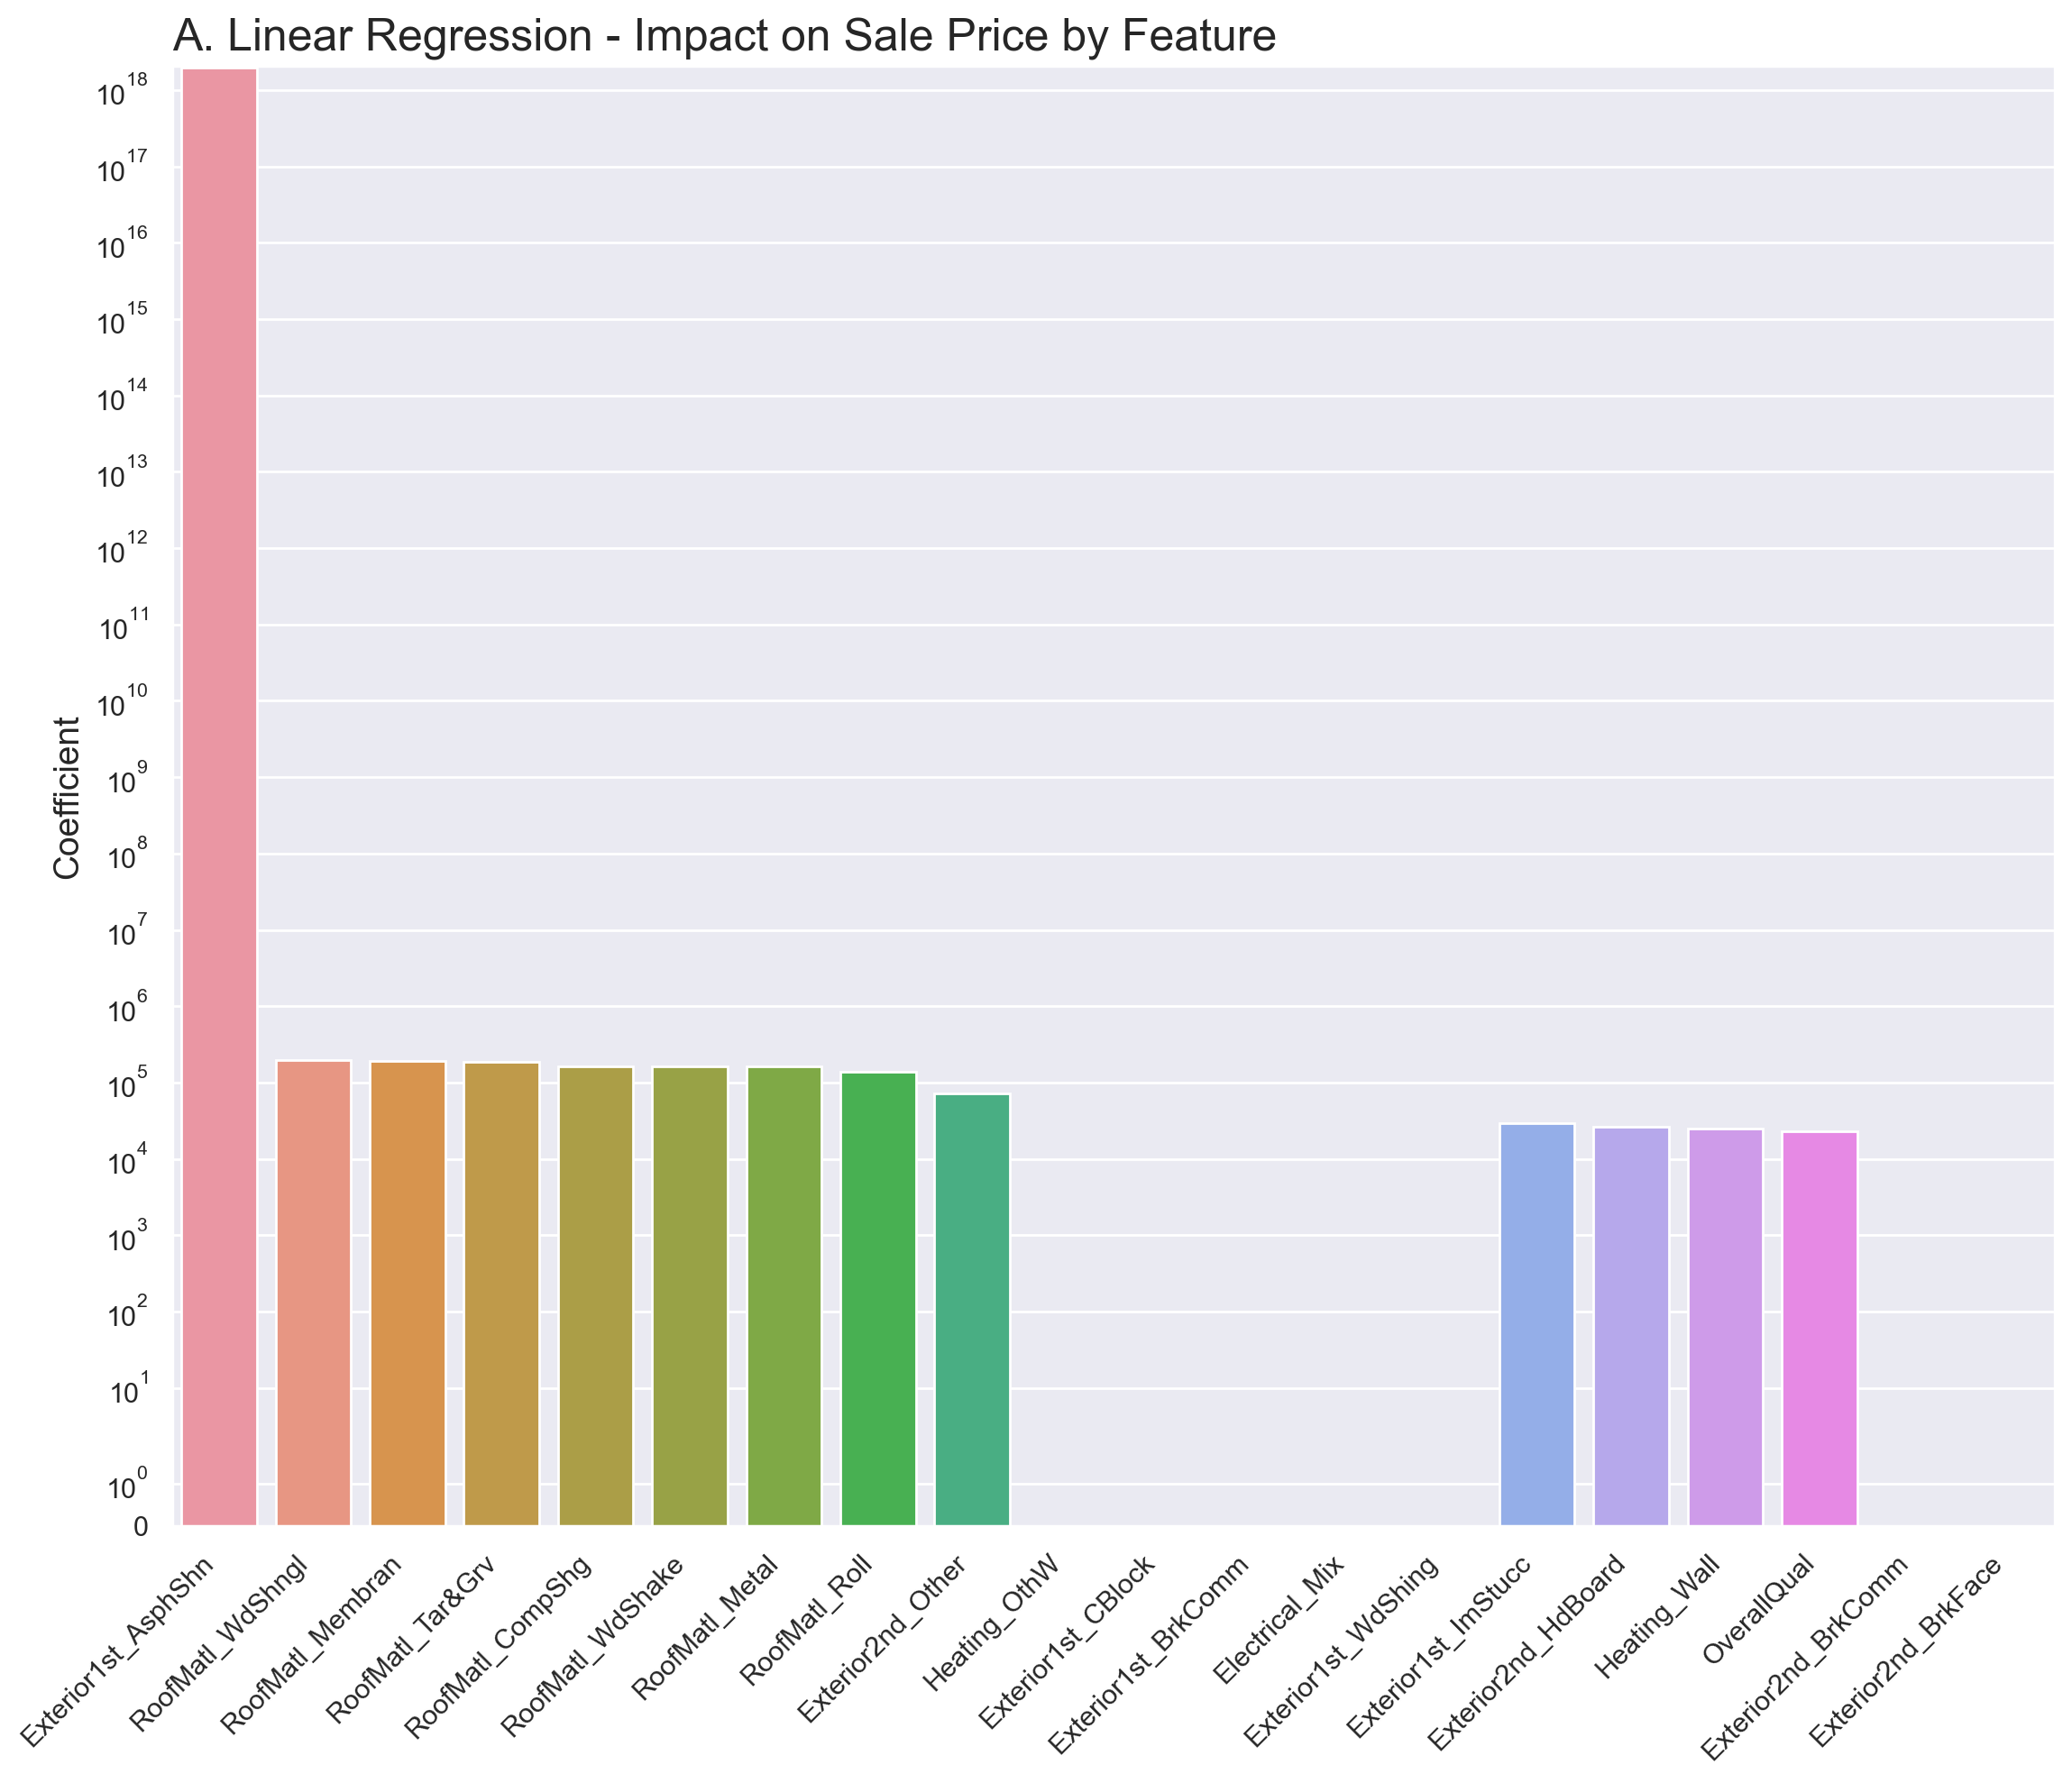

In [74]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,10))

sns.barplot(data=linreg_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('B. Linear Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.yscale('symlog')

plt.show()

### Lasso Regression with LassoCV

In [ ]:
# instantiate a LassoCV model
opt_lasso = LassoCV(alphas=np.logspace(0, 5, 200), cv=10)

# fit the model
opt_lasso.fit(X_train, y_train)

# display the optimal alpha
print('Optimal Alpha:', opt_lasso.alpha_)

In [ ]:
# instantiate the model
lasso = Lasso(alpha=opt_lasso.alpha_)

# fit the model
lasso.fit(X_train, y_train)

# calculate the scores
b_lasso_train = lasso.score(X_train, y_train)
b_lasso_test = lasso.score(X_test, y_test)
b_lasso_cv = (cross_val_score(lasso, X_train, y_train, cv = 10)).mean()

b_lasso_predictions_train = lasso.predict(X_train)
b_lasso_predictions = lasso.predict(X_test)

b_lasso_MSE = metrics.mean_squared_error(y_test, b_lasso_predictions)
b_lasso_MAE = metrics.mean_absolute_error(y_test, b_lasso_predictions)

# collect the scores in a dataframe to compare different models later
b_lasso_df = pd.DataFrame([{'train': b_lasso_train,
                            'test' : b_lasso_test,
                            'CV'   : b_lasso_cv,
                            'MSE'  : b_lasso_MSE,
                            'MAE'  : b_lasso_MAE}],
                            index = ['B. Lasso Regression'])

# score the model
print('B. Lasso Regression Scores: \n')
print('R-squared train score: ', b_lasso_train)
print('R-squared test score:  ', b_lasso_test)
print('R-squared CV score:    ', b_lasso_cv)
print('Mean Squared Error:    ', b_lasso_MSE)
print('Mean Absolute Error:   ', b_lasso_MAE)

In [ ]:
# display the model intercept
print('Intercept:', lasso.intercept_)

In [ ]:
# collect the model coefficients in a dataframe
lasso_coef = pd.DataFrame(list(zip(X_train.columns, lasso.coef_)), columns = ['variable','coefficient'])
lasso_coef['coef_abs'] = abs(lasso_coef['coefficient'])

# display the largest model coefficients
lasso_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

In [ ]:
# display the coefficients which has been reduced to 0
lasso_zeroed = lasso_coef[lasso_coef['coefficient'] == 0].shape[0]
print('Lasso Regression has zeroed',lasso_zeroed , 'coefficients.')
list(lasso_coef['variable'][lasso_coef['coefficient'] == 0].values)

In [ ]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=lasso_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('B. Lasso Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Ridge Regression with RidgeCV

In [ ]:
# instantiate a RidgeCV model
opt_ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)

# fit the model
opt_ridge.fit(X_train, y_train)

# display the optimal alpha
print('Optimal Alpha:', opt_ridge.alpha_)

In [ ]:
# instantiate the model
ridge = Ridge(alpha=opt_ridge.alpha_)

# fit the model
ridge.fit(X_train, y_train)

# calculate the scores
b_ridge_train = ridge.score(X_train, y_train)
b_ridge_test = ridge.score(X_test, y_test)
b_ridge_cv = (cross_val_score(ridge, X_train, y_train, cv = 10)).mean()

b_ridge_predictions_train = ridge.predict(X_train)
b_ridge_predictions = ridge.predict(X_test)

b_ridge_MSE = metrics.mean_squared_error(y_test, b_ridge_predictions)
b_ridge_MAE = metrics.mean_absolute_error(y_test, b_ridge_predictions)

# collect the scores in a dataframe to compare different models later
b_ridge_df = pd.DataFrame([{'train': b_ridge_train,
                            'test' : b_ridge_test,
                            'CV'   : b_ridge_cv,
                            'MSE'  : b_ridge_MSE,
                            'MAE'  : b_ridge_MAE}],
                            index = ['B. Ridge Regression'])

# score the model
print('B. Ridge Regression Scores: \n')
print('R-squared train score: ', b_ridge_train)
print('R-squared test score:  ', b_ridge_test)
print('R-squared CV score:    ', b_ridge_cv)
print('Mean Squared Error:    ', b_ridge_MSE)
print('Mean Absolute Error:   ', b_ridge_MAE)

In [ ]:
# display the model intercept
print('Intercept:', ridge.intercept_)

In [ ]:
# collect the model coefficients in a dataframe
ridge_coef = pd.DataFrame(list(zip(X_train.columns, ridge.coef_)), columns = ['variable','coefficient'])
ridge_coef['coef_abs'] = abs(ridge_coef['coefficient'])

# display the largest model coefficients
ridge_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

In [ ]:
# display the coefficients which has been reduced to 0
ridge_zeroed = ridge_coef[ridge_coef['coefficient'] == 0].shape[0]
print('Ridge Regression has zeroed',ridge_zeroed , 'coefficients.')
list(ridge_coef['variable'][ridge_coef['coefficient'] == 0].values)

In [ ]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=ridge_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('B. Ridge Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Elastic Net Regression with ElasticNetCV

In [75]:
# instantiate a ElasticnetCV model
opt_enet = ElasticNetCV(alphas=np.logspace(-4, 4, 10), l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                        max_iter = 100000, cv=10)

# fit the model
opt_enet.fit(X_train, y_train)

# display the optimal alpha and L1 ratio
print('Optimal Alpha:', opt_enet.alpha_)
print('Optimal L1 ratio:', opt_enet.l1_ratio_)

Optimal Alpha: 0.046415888336127774
Optimal L1 ratio: 0.5


In [76]:
# instantiate the model
enet = ElasticNet(alpha=opt_enet.alpha_, l1_ratio=opt_enet.l1_ratio_)

# fit the model
enet.fit(X_train, y_train)

# calculate the scores
b_enet_train = enet.score(X_train, y_train)
b_enet_test = enet.score(X_test, y_test)
b_enet_cv = (cross_val_score(enet, X_train, y_train, cv = 10)).mean()

b_enet_predictions_train = enet.predict(X_train)
b_enet_predictions = enet.predict(X_test)

b_enet_MSE = metrics.mean_squared_error(y_test, b_enet_predictions)
b_enet_MAE = metrics.mean_absolute_error(y_test, b_enet_predictions)

# collect the scores in a dataframe to compare different models later
b_enet_df = pd.DataFrame([{'train': b_enet_train,
                           'test' : b_enet_test,
                           'CV'   : b_enet_cv,
                           'MSE'  : b_enet_MSE,
                           'MAE'  : b_enet_MAE}],
                           index = ['B. Elastic Net Regression'])

# score the model
print('B. Elastic Net Regression Scores: \n')
print('R-squared train score: ', b_enet_train)
print('R-squared test score:  ', b_enet_test)
print('R-squared CV score:    ', b_enet_cv)
print('Mean Squared Error:    ', b_enet_MSE)
print('Mean Absolute Error:   ', b_enet_MAE)

B. Elastic Net Regression Scores: 

R-squared train score:  0.7187145531541337
R-squared test score:   0.694842784133713
R-squared CV score:     0.6989291240473159
Mean Squared Error:     1059607276.1378415
Mean Absolute Error:    24535.615243730903


In [77]:
# display the model intercept
print('Intercept:', enet.intercept_)

Intercept: -45032.6756300698


In [78]:
# collect the model coefficients in a dataframe
enet_coef = pd.DataFrame(list(zip(X_train.columns, enet.coef_)), columns = ['variable','coefficient'])
enet_coef['coef_abs'] = abs(enet_coef['coefficient'])

# display the largest model coefficients
enet_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

,variable,coefficient,coef_abs
0,OverallQual,22198.852656,22198.852656
38,Exterior1st_WdShing,-8450.311541,8450.311541
52,Exterior2nd_WdShing,-7723.236463,7723.236463
12,GarageFinish,7245.447391,7245.447391
27,Exterior1st_BrkFace,6992.705843,6992.705843
33,Exterior1st_Plywood,6433.715621,6433.715621
11,FireplaceQu,6227.042999,6227.042999
7,HeatingQC,5487.029344,5487.029344
35,Exterior1st_Stucco,-5437.316483,5437.316483
57,Heating_GasW,5409.746915,5409.746915


In [79]:
# display the coefficients which has been reduced to 0
enet_zeroed = enet_coef[enet_coef['coefficient'] == 0].shape[0]
print('Elastic Net Regression has zeroed',enet_zeroed , 'coefficients.')
list(enet_coef['variable'][enet_coef['coefficient'] == 0].values)

Elastic Net Regression has zeroed 1 coefficients.


['Exterior1st_AsphShn']

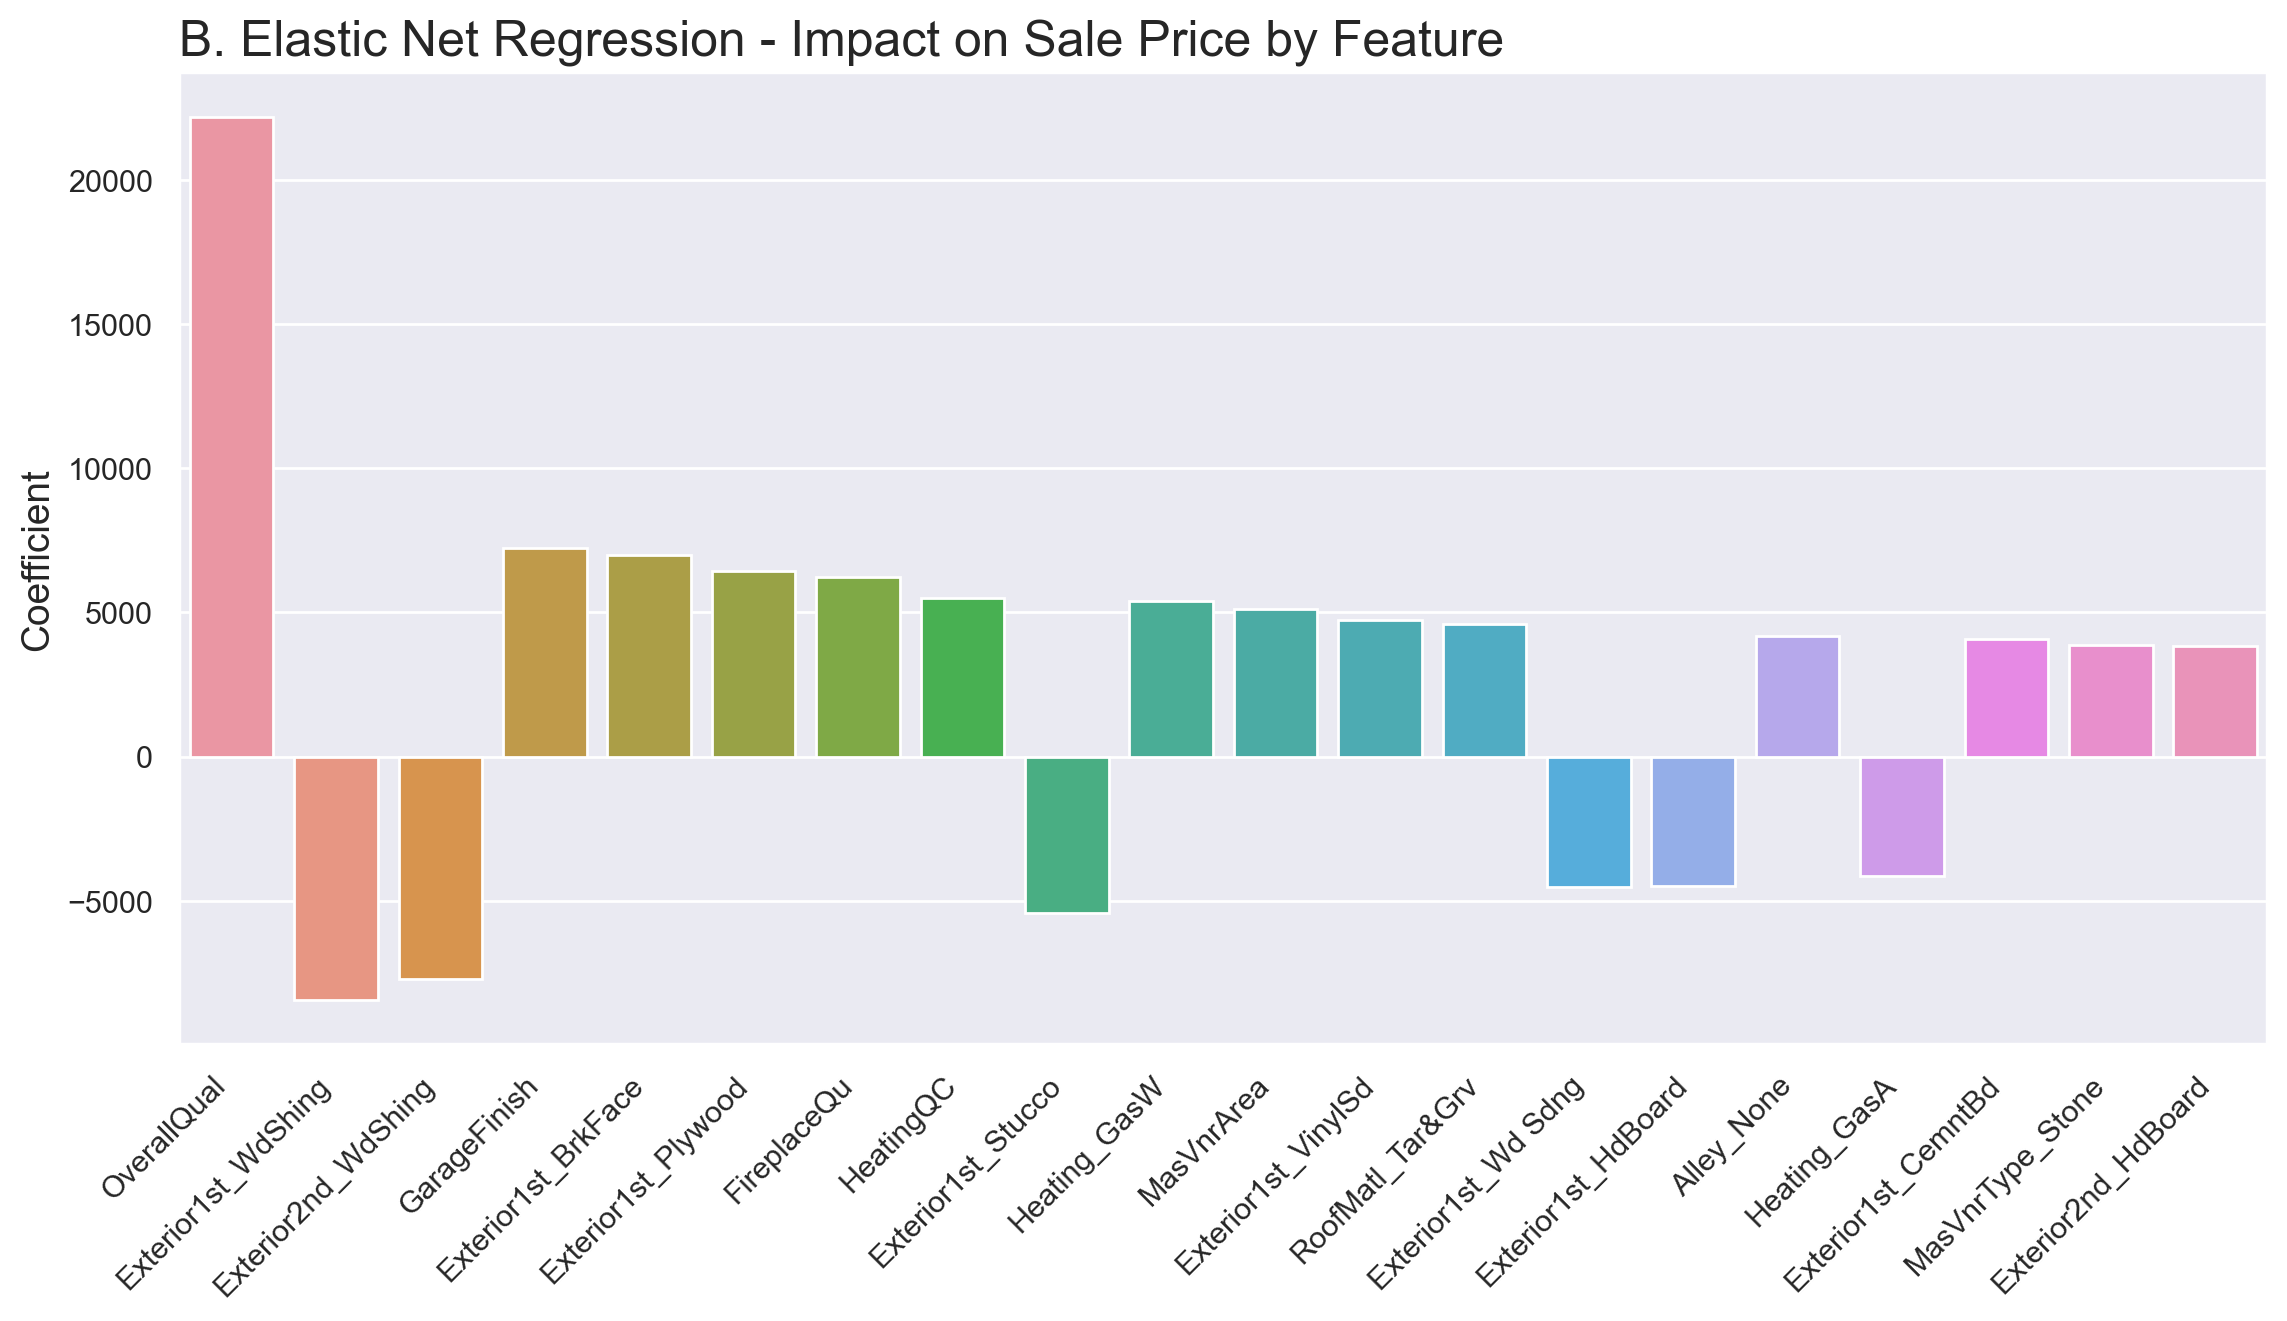

In [80]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=enet_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('B. Elastic Net Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Model Set Score Evaluation

In [81]:
B_models = pd.concat([b_linreg_df, b_lasso_df, b_ridge_df, b_enet_df], axis = 0)
B_models.round(decimals=5)

,train,test,CV,MSE,MAE
B. Linear Reg,0.73410,-6.784485e+24,-2.377302e+23,2.355799e+34,1.194888e+16
B. Elastic Net Regression,0.71871,6.948400e-01,6.989300e-01,1.059607e+09,2.453562e+04


In [ ]:
### COMMENTS



In [ ]:
# plot the predicted y values against the actual y values by the elastic net method
fig, ax = plt.subplots(ncols=2, figsize=(14, 7), constrained_layout=True)

fig.suptitle('B. Elastic Net Regression - Predicted vs Actual Sale Price', x=0.52, horizontalalignment='right', fontsize=18)

ax[0].scatter(b_enet_predictions_train, y_train, s=30, color = 'lightseagreen', zorder=10)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='r', lw=2)
ax[0].set_ylabel('Actual Sale Price')
ax[0].set_xlabel('Predicted Sale Price')
ax[0].set_title('Train Set')

ax[1].scatter(b_enet_predictions, y_test, s=30, color='lightseagreen', zorder=10)
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r', lw=2)
ax[1].set_ylabel('Actual Sale Price')
ax[1].set_xlabel('Predicted Sale Price')
ax[1].set_title('Test Set')

plt.show()

In [ ]:
### CONCLUSIONS



## *C. Using changeable characteristics and residuals from the fixed ones*

In [ ]:
# use the residuals from the first set of models (fixed features) as target
y_train = a_res_train['residuals']
y_test = a_res_test['residuals']

### Linear Regression (without regularisation)

In [ ]:
# instantiate the model
linreg = LinearRegression()

# fit the model
linreg.fit(X_train, y_train)

# calculate the scores
c_linreg_train = linreg.score(X_train, y_train)
c_linreg_test = linreg.score(X_test, y_test)
c_linreg_cv = (cross_val_score(linreg, X_train, y_train, cv = 10)).mean()

c_linreg_predictions_train = linreg.predict(X_train)
c_linreg_predictions = linreg.predict(X_test)

c_linreg_MSE = metrics.mean_squared_error(y_test, c_linreg_predictions)
c_linreg_MAE = metrics.mean_absolute_error(y_test, c_linreg_predictions)

# collect the scores in a dataframe to compare different models later
c_linreg_df = pd.DataFrame([{'train': c_linreg_train,
                             'test' : c_linreg_test,
                             'CV'   : c_linreg_cv,
                             'MSE'  : c_linreg_MSE,
                             'MAE'  : c_linreg_MAE}],
                             index = ['C. Linear Regression'])

# score the model
print('C. Linear Regression Scores: \n')
print('R-squared train score: ', c_linreg_train)
print('R-squared test score:  ', c_linreg_test)
print('R-squared CV score:    ', c_linreg_cv)
print('Mean Squared Error:    ', c_linreg_MSE)
print('Mean Absolute Error:   ', c_linreg_MAE)

In [ ]:
# display the model intercept
print('Intercept:', linreg.intercept_)

In [ ]:
# collect the model coefficients in a dataframe
linreg_coef = pd.DataFrame(list(zip(X_train.columns, linreg.coef_)), columns = ['variable','coefficient'])
linreg_coef['coef_abs'] = abs(linreg_coef['coefficient'])

# display the largest model coefficients
linreg_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

In [ ]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,10))

sns.barplot(data=linreg_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('C. Linear Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.yscale('symlog')

plt.show()

### Lasso Regression with LassoCV

In [ ]:
# instantiate a LassoCV model
opt_lasso = LassoCV(alphas=np.logspace(0, 5, 200), cv=10)

# fit the model
opt_lasso.fit(X_train, y_train)

# display the optimal alpha
print('Optimal Alpha:', opt_lasso.alpha_)

In [ ]:
# instantiate the model
lasso = Lasso(alpha=opt_lasso.alpha_)

# fit the model
lasso.fit(X_train, y_train)

# calculate the scores
c_lasso_train = lasso.score(X_train, y_train)
c_lasso_test = lasso.score(X_test, y_test)
c_lasso_cv = (cross_val_score(lasso, X_train, y_train, cv = 10)).mean()

c_lasso_predictions_train = lasso.predict(X_train)
c_lasso_predictions = lasso.predict(X_test)

c_lasso_MSE = metrics.mean_squared_error(y_test, c_lasso_predictions)
c_lasso_MAE = metrics.mean_absolute_error(y_test, c_lasso_predictions)

# collect the scores in a dataframe to compare different models later
c_lasso_df = pd.DataFrame([{'train': c_lasso_train,
                            'test' : c_lasso_test,
                            'CV'   : c_lasso_cv,
                            'MSE'  : c_lasso_MSE,
                            'MAE'  : c_lasso_MAE}],
                            index = ['C. Lasso Regression'])

# score the model
print('C. Lasso Regression Scores: \n')
print('R-squared train score: ', c_lasso_train)
print('R-squared test score:  ', c_lasso_test)
print('R-squared CV score:    ', c_lasso_cv)
print('Mean Squared Error:    ', c_lasso_MSE)
print('Mean Absolute Error:   ', c_lasso_MAE)

In [ ]:
# display the model intercept
print('Intercept:', lasso.intercept_)

In [ ]:
# collect the model coefficients in a dataframe
lasso_coef = pd.DataFrame(list(zip(X_train.columns, lasso.coef_)), columns = ['variable','coefficient'])
lasso_coef['coef_abs'] = abs(lasso_coef['coefficient'])

# display the largest model coefficients
lasso_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

In [ ]:
# display the coefficients which has been reduced to 0
lasso_zeroed = lasso_coef[lasso_coef['coefficient'] == 0].shape[0]
print('Lasso Regression has zeroed',lasso_zeroed , 'coefficients.')
list(lasso_coef['variable'][lasso_coef['coefficient'] == 0].values)

In [ ]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=lasso_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('C. Lasso Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Ridge Regression with RidgeCV

In [ ]:
# instantiate a RidgeCV model
opt_ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)

# fit the model
opt_ridge.fit(X_train, y_train)

# display the optimal alpha
print('Optimal Alpha:', opt_ridge.alpha_)

In [ ]:
# instantiate the model
ridge = Ridge(alpha=opt_ridge.alpha_)

# fit the model
ridge.fit(X_train, y_train)

# calculate the scores
c_ridge_train = ridge.score(X_train, y_train)
c_ridge_test = ridge.score(X_test, y_test)
c_ridge_cv = (cross_val_score(ridge, X_train, y_train, cv = 10)).mean()

c_ridge_predictions_train = ridge.predict(X_train)
c_ridge_predictions = ridge.predict(X_test)

c_ridge_MSE = metrics.mean_squared_error(y_test, c_ridge_predictions)
c_ridge_MAE = metrics.mean_absolute_error(y_test, c_ridge_predictions)

# collect the scores in a dataframe to compare different models later
c_ridge_df = pd.DataFrame([{'train': c_ridge_train,
                            'test' : c_ridge_test,
                            'CV'   : c_ridge_cv,
                            'MSE'  : c_ridge_MSE,
                            'MAE'  : c_ridge_MAE}],
                            index = ['C. Ridge Regression'])

# score the model
print('C. Ridge Regression Scores: \n')
print('R-squared train score: ', c_ridge_train)
print('R-squared test score:  ', c_ridge_test)
print('R-squared CV score:    ', c_ridge_cv)
print('Mean Squared Error:    ', c_ridge_MSE)
print('Mean Absolute Error:   ', c_ridge_MAE)

In [ ]:
# display the model intercept
print('Intercept:', ridge.intercept_)

In [ ]:
# collect the model coefficients in a dataframe
ridge_coef = pd.DataFrame(list(zip(X_train.columns, ridge.coef_)), columns = ['variable','coefficient'])
ridge_coef['coef_abs'] = abs(ridge_coef['coefficient'])

# display the largest model coefficients
ridge_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

In [ ]:
# display the coefficients which has been reduced to 0
ridge_zeroed = ridge_coef[ridge_coef['coefficient'] == 0].shape[0]
print('Ridge Regression has zeroed',ridge_zeroed , 'coefficients.')
list(ridge_coef['variable'][ridge_coef['coefficient'] == 0].values)

In [ ]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=ridge_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('C. Ridge Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Elastic Net Regression with ElasticNetCV

In [ ]:
# instantiate a ElasticnetCV model
opt_enet = ElasticNetCV(alphas=np.logspace(-4, 4, 10), l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                        max_iter = 100000, cv=10)

# fit the model
opt_enet.fit(X_train, y_train)

# display the optimal alpha and L1 ratio
print('Optimal Alpha:', opt_enet.alpha_)
print('Optimal L1 ratio:', opt_enet.l1_ratio_)

In [ ]:
# instantiate the model
enet = ElasticNet(alpha=opt_enet.alpha_, l1_ratio=opt_enet.l1_ratio_)

# fit the model
enet.fit(X_train, y_train)

# calculate the scores
c_enet_train = enet.score(X_train, y_train)
c_enet_test = enet.score(X_test, y_test)
c_enet_cv = (cross_val_score(enet, X_train, y_train, cv = 10)).mean()

c_enet_predictions_train = enet.predict(X_train)
c_enet_predictions = enet.predict(X_test)

c_enet_MSE = metrics.mean_squared_error(y_test, c_enet_predictions)
c_enet_MAE = metrics.mean_absolute_error(y_test, c_enet_predictions)

# collect the scores in a dataframe to compare different models later
c_enet_df = pd.DataFrame([{'train': c_enet_train,
                           'test' : c_enet_test,
                           'CV'   : c_enet_cv,
                           'MSE'  : c_enet_MSE,
                           'MAE'  : c_enet_MAE}],
                           index = ['C. Elastic Net Regression'])

# score the model
print('C. Elastic Net Regression Scores: \n')
print('R-squared train score: ', c_enet_train)
print('R-squared test score:  ', c_enet_test)
print('R-squared CV score:    ', c_enet_cv)
print('Mean Squared Error:    ', c_enet_MSE)
print('Mean Absolute Error:   ', c_enet_MAE)

In [ ]:
# display the model intercept
print('Intercept:', enet.intercept_)

In [ ]:
# collect the model coefficients in a dataframe
enet_coef = pd.DataFrame(list(zip(X_train.columns, enet.coef_)), columns = ['variable','coefficient'])
enet_coef['coef_abs'] = abs(enet_coef['coefficient'])

# display the largest model coefficients
enet_coef.sort_values(by = 'coef_abs', ascending = False)[:20]

In [ ]:
# display the coefficients which has been reduced to 0
enet_zeroed = enet_coef[enet_coef['coefficient'] == 0].shape[0]
print('Elastic Net Regression has zeroed',enet_zeroed , 'coefficients.')
list(enet_coef['variable'][enet_coef['coefficient'] == 0].values)

In [ ]:
# plot the coefficients
fig, ax = plt.subplots(figsize = (12,6))

sns.barplot(data=enet_coef.sort_values(by='coef_abs', ascending=False)[:20], 
            x='variable', y='coefficient', ax=ax)
ax.set_title('C. Elastic Net Regression - Impact on Sale Price by Feature', loc='left', fontsize=18)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

### Model Set Score Evaluation

In [ ]:
C_models = pd.concat([c_linreg_df, c_lasso_df, c_ridge_df, c_enet_df], axis = 0)
C_models.round(decimals=5)

In [ ]:
### COMMENTS



In [ ]:
# plot the predicted y values against the actual y values by the elastic net method
fig, ax = plt.subplots(ncols=2, figsize=(14, 7), constrained_layout=True)

fig.suptitle('C. Elastic Net Regression - Predicted vs Actual Sale Price', x=0.52, horizontalalignment='right', fontsize=18)

ax[0].scatter(c_enet_predictions_train, y_train, s=30, color = 'lightseagreen', zorder=10)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='r', lw=2)
ax[0].set_ylabel('Actual Sale Price')
ax[0].set_xlabel('Predicted Sale Price')
ax[0].set_title('Train Set')

ax[1].scatter(c_enet_predictions, y_test, s=30, color='lightseagreen', zorder=10)
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r', lw=2)
ax[1].set_ylabel('Actual Sale Price')
ax[1].set_xlabel('Predicted Sale Price')
ax[1].set_title('Test Set')

plt.show()

In [ ]:
### CONCLUSIONS




<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [85]:
# check the columns shared by both dataframes (fixed and mutable features)
for x in df_f.columns:
    if x in df_m.columns:
        print(x)

YrSold
SalePrice


In [ ]:
# remove the columns from one dataframe
df_m = df_m.drop(['YrSold', 'SalePrice'], axis = 1)

In [ ]:
# merge the dataframes
df = pd.concat([df_f, df_m], axis = 1)

print(df.shape)
df.head()

In [ ]:
# check SaleType values
df.SaleType.value_counts(normalize=True)

In [ ]:
# check SaleCondition values
df.SaleCondition.value_counts(normalize=True)

In [ ]:
# binarise the target variable using 1 for Abnormal and 0 for everything else
y_binary = [1 if value == 'Abnorml' else 0 for value in df.SaleCondition]

df.drop('SaleCondition', axis = 1, inplace = True)
df['SaleCond_Abnormal'] = y_binary

In [ ]:
# check SaleCondition updated values
df.SaleCond_Abnormal.value_counts(normalize=True)

In [ ]:
# dummify categorical variables
df_dum = pd.get_dummies(df, columns=[x for x in df_f.columns if x in nominal_vars], drop_first=True)